In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# be careful with that:
import warnings
warnings.filterwarnings('ignore')

In [371]:
# load data

data_heatmap = pd.read_csv('../datasets/train/data_heatmap_train.csv')
data_metrics = pd.read_csv('../datasets/train/data_metrics_train.csv')

In [372]:
cb_333519 = ['ID_1184', 'ID_1281', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522',
       'ID_1544', 'ID_162', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888',
       'ID_1929', 'ID_2076', 'ID_2097', 'ID_2226', 'ID_2249', 'ID_2268',
       'ID_2331', 'ID_2339', 'ID_2386', 'ID_2396', 'ID_2438', 'ID_258',
       'ID_2609', 'ID_2680', 'ID_2863', 'ID_2883', 'ID_2908', 'ID_3061',
       'ID_3243', 'ID_3250', 'ID_3314', 'ID_3382', 'ID_3397', 'ID_3402',
       'ID_3420', 'ID_3459', 'ID_3470', 'ID_3540', 'ID_398', 'ID_409',
       'ID_484', 'ID_489', 'ID_526', 'ID_549', 'ID_580', 'ID_665',
       'ID_810', 'ID_84', 'ID_857', 'ID_86', 'ID_905', 'ID_927', 'ID_934',
       'ID_962', 'ID_986']

cb_333346 = ['ID_1247', 'ID_162', 'ID_2534', 'ID_2742', 'ID_526', 'ID_2201',
       'ID_1165', 'ID_743', 'ID_199', 'ID_2145', 'ID_2569', 'ID_643',
       'ID_1305', 'ID_3180', 'ID_3158', 'ID_136', 'ID_293', 'ID_1753',
       'ID_1849', 'ID_2226', 'ID_1462', 'ID_626', 'ID_2863', 'ID_3243',
       'ID_3250', 'ID_1708', 'ID_1238', 'ID_580', 'ID_84', 'ID_2568',
       'ID_2340', 'ID_1803', 'ID_3470', 'ID_139', 'ID_2619', 'ID_2908',
       'ID_1281', 'ID_3308', 'ID_2883', 'ID_1320', 'ID_1333', 'ID_1062',
       'ID_149', 'ID_260', 'ID_599', 'ID_1513', 'ID_3402', 'ID_1888',
       'ID_2972', 'ID_398', 'ID_2339', 'ID_1030', 'ID_3382', 'ID_2076',
       'ID_1646', 'ID_1077', 'ID_10', 'ID_1153', 'ID_1533', 'ID_2609',
       'ID_1214', 'ID_810', 'ID_2097', 'ID_2386', 'ID_1585', 'ID_549',
       'ID_3420', 'ID_3397', 'ID_2006', 'ID_561', 'ID_1542', 'ID_1570',
       'ID_1819', 'ID_1413', 'ID_1240', 'ID_793', 'ID_831', 'ID_3188',
       'ID_1437', 'ID_556', 'ID_1134', 'ID_314', 'ID_2836', 'ID_1483',
       'ID_2676', 'ID_665', 'ID_15', 'ID_2755', 'ID_2194', 'ID_1682',
       'ID_2775', 'ID_1923', 'ID_1846', 'ID_1262', 'ID_3314', 'ID_1448',
       'ID_1770', 'ID_2626', 'ID_3296', 'ID_489', 'ID_1963', 'ID_1268',
       'ID_1568', 'ID_1094', 'ID_2267', 'ID_409', 'ID_1650', 'ID_1522',
       'ID_927', 'ID_2302', 'ID_1929', 'ID_1435', 'ID_1353']

# Metrics exploration

In [373]:
dm = data_metrics.drop(columns = ['grid_id','domain','Unnamed: 0','webview_height','webview_width'])

In [374]:
dm.isna().sum()

displays                      43
clicks                        53
landed_clicks                 53
non_bounced_clicks            53
closing_events               348
avg_last_second_framerate     53
sov_short_ttc                197
sov_short_ttc_global         197
sov_short_ttc_score          197
broken                        43
dtype: int64

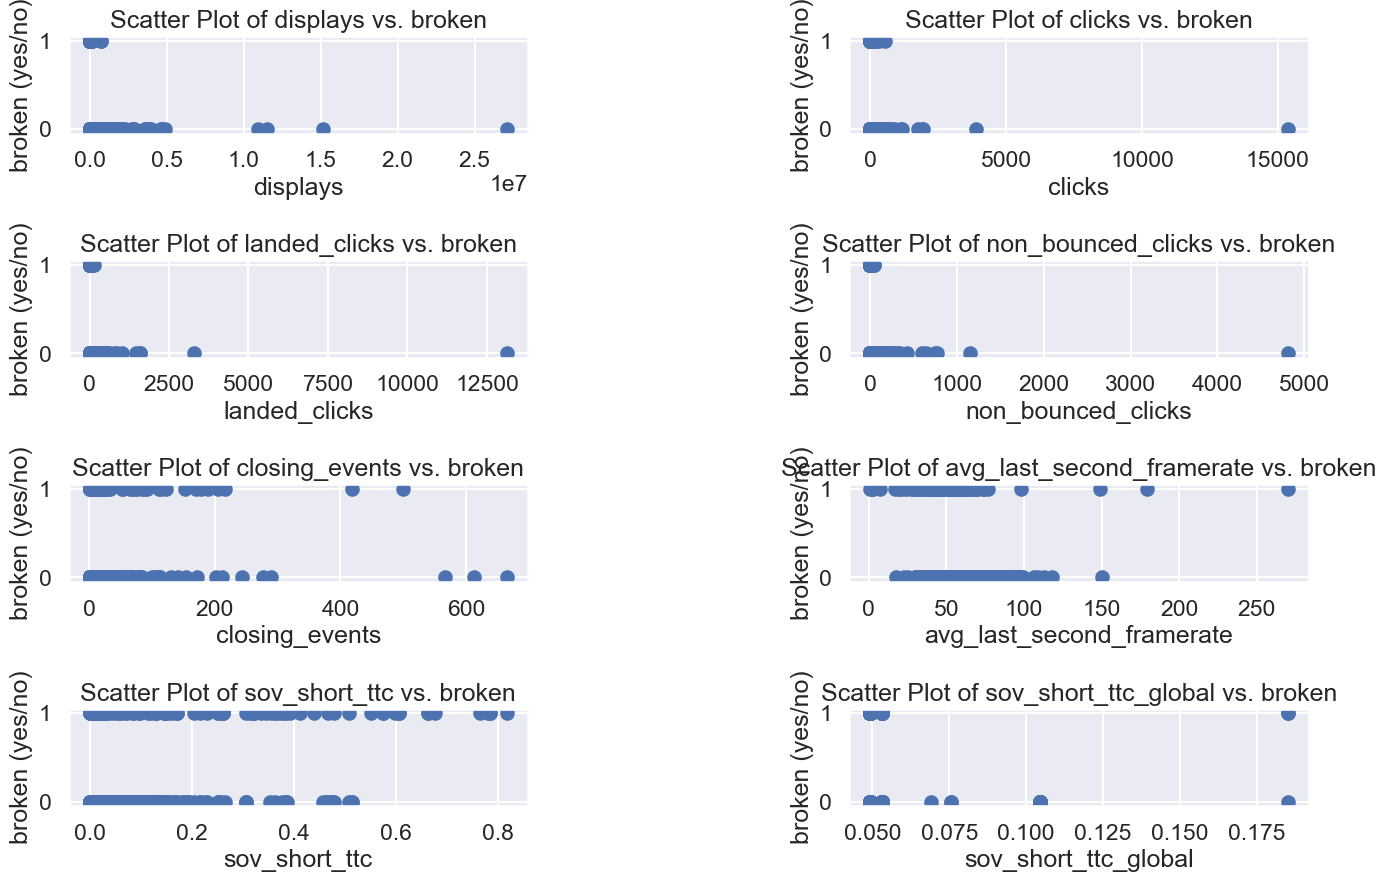

In [375]:
feats = dm.columns[:-1]

fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (16, 10)) 
fig.subplots_adjust(hspace = 1.3, wspace = 0.7)

for i, f in enumerate(feats[:-1]):
    row = i // 2
    col = i % 2
    comb = dm[[f,'broken']].dropna()
    axes[row, col].scatter(comb[f],comb['broken'])
    axes[row, col].set_title(f'Scatter Plot of {feats[i]} vs. broken')
    axes[row, col].set_xlabel(f'{feats[i]}')
    axes[row, col].set_ylabel('broken (yes/no)')
plt.show()

## Train test split and Standardize

In [376]:
data_metrics = data_metrics.drop(data_metrics.loc[data_metrics.broken.isna()].index)
y = data_metrics['broken']
X = data_metrics.drop(columns = ['grid_id','domain','Unnamed: 0','webview_height','webview_width','broken']).ffill(0)

X_train, X_test, y_train , y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 1)

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [377]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


clf = tree.DecisionTreeClassifier(random_state = 1)
clf = clf.fit(X_train, y_train)
confusion_matrix(y_test,clf.predict(X_test))

array([[312,   8],
       [ 14,  17]])

In [378]:
prev_best_val = -1
prev_best = -float('inf')
for i in range(2,100):
    clf = RandomForestClassifier(max_depth = i, random_state = 0)
    clf = clf.fit(X_train, y_train)
    if confusion_matrix(y_test,clf.predict(X_test))[1,1] > prev_best:
        prev_best = confusion_matrix(y_test,clf.predict(X_test))[1,1]
        prev_best_val = i

In [379]:
print(prev_best_val, prev_best)
clf = RandomForestClassifier(max_depth = 14, random_state = 0)
clf = clf.fit(X_train, y_train)

10 13


model 1 AUC score: 0.0732358870967742


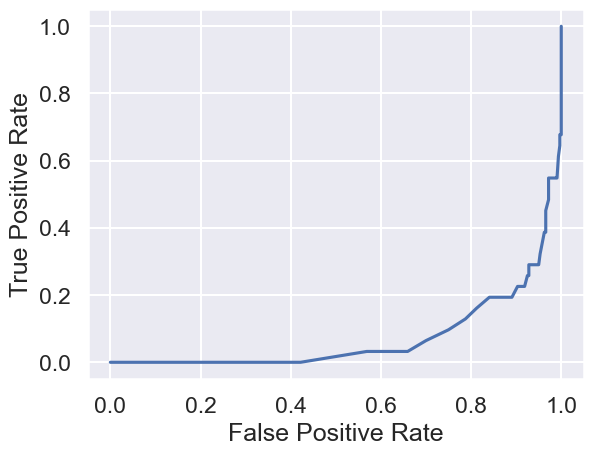

In [380]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(y_test, clf.predict_proba(X_test)[:,0])
print(f'model 1 AUC score: {roc_auc_score(y_test, clf.predict_proba(X_test)[:,0])}')

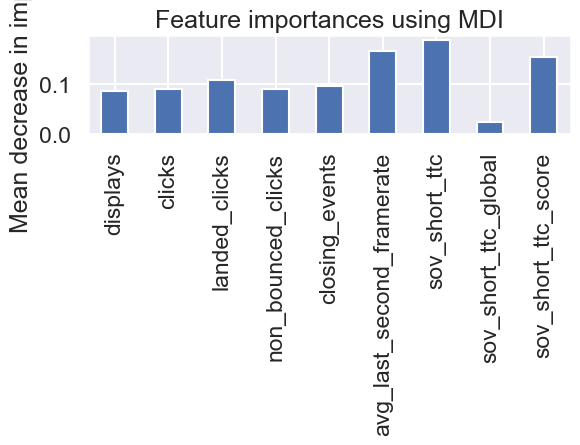

In [381]:
importances = clf.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)
#std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

model 1 AUC score: 0.23830645161290323


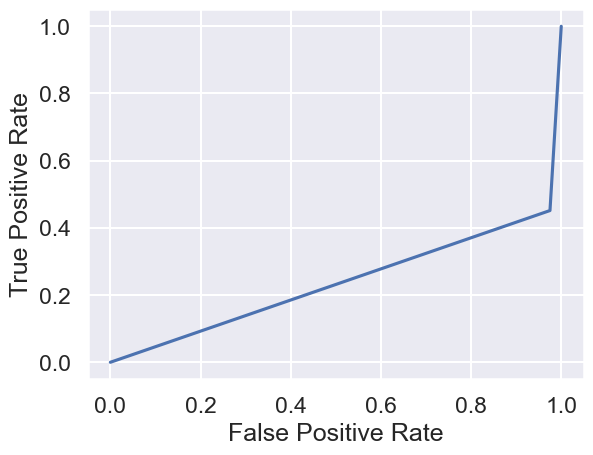

In [382]:
clf = tree.DecisionTreeClassifier(random_state = 1)
clf = clf.fit(X_train, y_train)
confusion_matrix(y_test,clf.predict(X_test))

plot_roc_curve(y_test, clf.predict_proba(X_test)[:,0])
print(f'model 1 AUC score: {roc_auc_score(y_test, clf.predict_proba(X_test)[:,0])}')

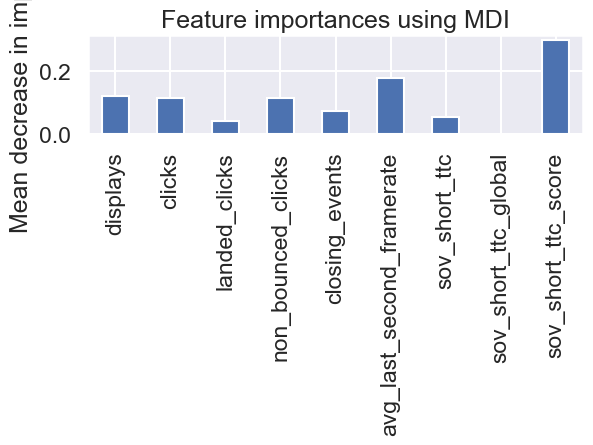

In [383]:
importances = clf.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)
#std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

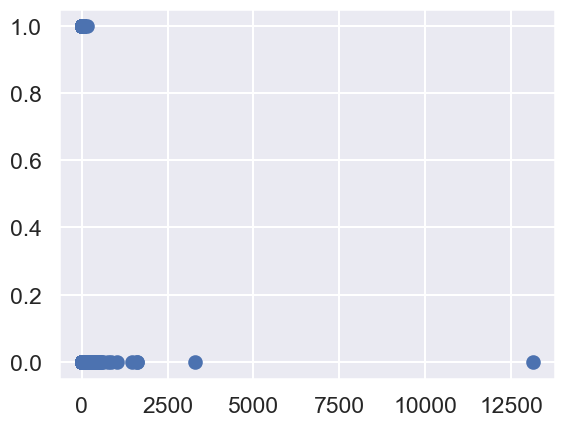

In [384]:
fff = 'landed_clicks'
comb = dm[[fff, 'broken']].dropna()
plt.scatter(comb[fff],comb['broken'])

<AxesSubplot: ylabel='Frequency'>

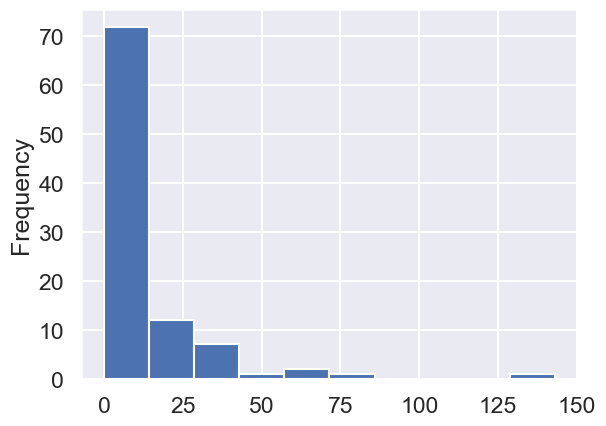

In [385]:
comb[comb.broken==1]['landed_clicks'].plot.hist()

<AxesSubplot: ylabel='Frequency'>

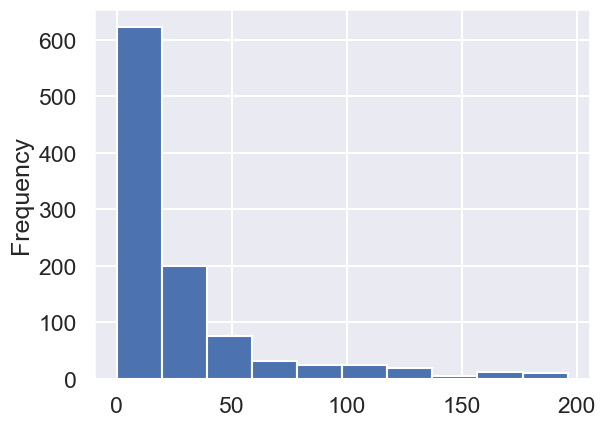

In [386]:
comb[(comb.broken==0) & (comb.landed_clicks < 200)]['landed_clicks'].plot.hist()

In [387]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [388]:
#LG = LogisticRegression(penalty = 'elasticnet', solver = 'saga')

# params = dict()
# #params['alpha']    = np.logspace(-5, 5, 100, endpoint=True)
# params['l1_ratio'] = np.arange(0, 1, 0.01)
#rs_cv = RandomizedSearchCV(LG, params, n_iter = 100, scoring=None, cv=5, verbose=0, refit=True)

LG = LogisticRegression(solver='saga', tol=1e-2, max_iter= 200,
                           random_state=0)
distributions = dict(C= uniform(loc=0, scale=4),
                      penalty=['l2', 'l1'])

rs_cv = RandomizedSearchCV(LG, distributions, random_state=0)
rs_cv.fit(X_train, y_train)

RandomizedSearchCV(estimator=LogisticRegression(max_iter=200, random_state=0,
                                                solver='saga', tol=0.01),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1c2467640>,
                                        'penalty': ['l2', 'l1']},
                   random_state=0)

In [389]:
y_pred     = rs_cv.predict(X_test)
R2_score   = rs_cv.score(X_test, y_test)
RMSE_score = confusion_matrix(y_test, y_pred)

R2_score, RMSE_score, rs_cv.best_params_ 

(0.9145299145299145,
 array([[315,   5],
        [ 25,   6]]),
 {'C': 2.195254015709299, 'penalty': 'l1'})

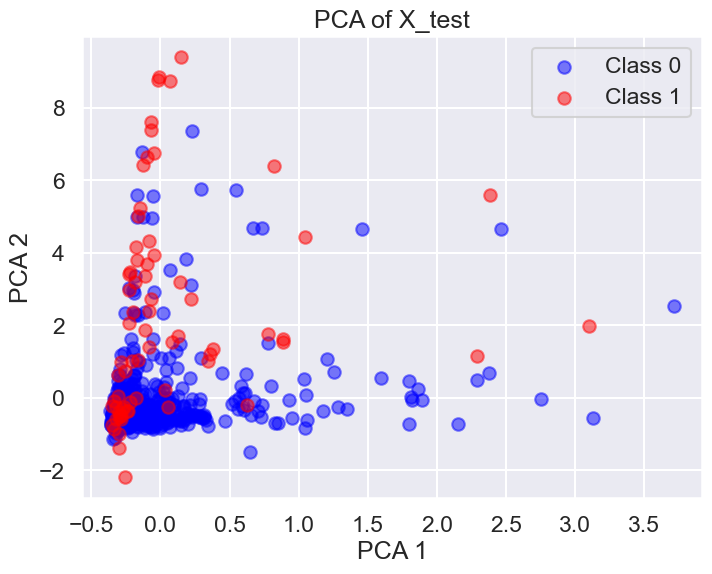

Explained variance by PCA component: [0.40447353 0.22720593]
Total variance explained by 2 components: 63.17%


In [390]:
from sklearn.decomposition import PCA

pca   = PCA(n_components = 2)
X_pca = pca.fit_transform(X_train)

X_pca_red = X_pca[X_pca[:, 0] < 4]
y_pca_red = y_train[X_pca[:, 0] < 4]

plt.figure(figsize=(8, 6))
for label, color in zip([0, 1], ['blue', 'red']):
    plt.scatter(X_pca_red[y_pca_red == label, 0], 
                X_pca_red[y_pca_red == label, 1], 
                c = color, 
                label = f'Class {label}', 
                alpha = 0.5)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of X_test')
plt.legend()
plt.show()

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PCA component: {explained_variance}")
print(f"Total variance explained by 2 components: {np.sum(explained_variance) * 100:.2f}%")

# plt.figure(figsize=(6, 4))
# plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, 
#         align='center', label='Individual explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component')
# plt.title('Explained Variance by PCA Components')
# plt.legend()
# plt.tight_layout()
# plt.show()

# MVU

In [244]:
#https://github.com/buquicchiol/MaximumVarianceUnfolding/blob/master/MVU.py

#################################
## 1) MVU Code:
#################################
import cvxpy as cp
from scipy.sparse.csgraph import laplacian
from sklearn.neighbors import NearestNeighbors

class DisconnectError(Exception):
    """
    An error class to catch if the graph has unconnected regions.
    """

    def __init__(self, message):
        self.message = message


class MaximumVarianceUnfolding:

    def __init__(self, equation="berkley", solver=cp.SCS, solver_tol=1e-2,
                 eig_tol=1.0e-10, solver_iters=2500, warm_start=False, seed=None):
        """
        :param equation: A string either "berkley" or "wikipedia" to represent
                         two different equations for the same problem.
        :param solver: A CVXPY solver object.
        :param solver_tol: A float representing the tolerance the solver uses to know when to stop.
        :param eig_tol: The positive semi-definite constraint is only so accurate, this sets
                        eigenvalues that lie in -eig_tol < 0 < eig_tol to 0.
        :param solver_iters: The max number of iterations the solver will go through.
        :param warm_start: Whether or not to use a warm start for the solver.
                           Useful if you are running multiple tests on the same data.
        :param seed: The numpy seed for random numbers.
        """
        self.equation = equation
        self.solver = solver
        self.solver_tol = solver_tol
        self.eig_tol = eig_tol
        self.solver_iters = solver_iters
        self.warm_start = warm_start
        self.seed = seed
        self.neighborhood_graph = None

    def fit(self, data, k, dropout_rate=.2):
        """
        The method to fit an MVU model to the data.
        :param data: The data to which the model will be fitted.
        :param k: The number of neighbors to fix.
        :param dropout_rate: The number of neighbors to discount.
        :return: Embedded Gramian: The Gramian matrix of the embedded data.
        """
        # Number of data points in the set
        n = data.shape[0]

        # Set the seed
        np.random.seed(self.seed)

        # Calculate the nearest neighbors of each data point and build a graph
        N = NearestNeighbors(n_neighbors=k).fit(data).kneighbors_graph(data).todense()
        N = np.array(N)

        # Randomly drop certain connections.
        # Not the most efficient way but with this implementation random
        #  cuts that disconnect the graph will be caught.
        for i in range(n):
            for j in range(n):
                if N[i, j] == 1 and np.random.random() < dropout_rate:
                    N[i, j] = 0.

        # Save the neighborhood graph to be accessed latter
        self.neighborhood_graph = N

        # To check for disconnected regions in the neighbor graph
        lap = laplacian(N, normed=True)
        eigvals, _ = np.linalg.eig(lap)

        for e in eigvals:
            if e == 0. and self.solver_iters is None:
                raise DisconnectError("DISCONNECTED REGIONS IN NEIGHBORHOOD GRAPH. "
                                      "PLEASE SPECIFY MAX ITERATIONS FOR THE SOLVER")

        # Declare some CVXPy variables
        # Gramian of the original data
        P = cp.Constant(data.dot(data.T))/10**6
        # The projection of the Gramian
        Q = cp.Variable((n, n), PSD=True)
        # Initialized to zeros
        Q.value = np.zeros((n, n))
        # A shorter way to call a vector of 1's
        ONES = cp.Constant(np.ones((n, 1)))
        # A variable to keep the notation consistent with the Berkley lecture
        T = cp.Constant(n)

        # Declare placeholders to get rid of annoying warnings
        objective = None
        constraints = []

        # Wikipedia Solution
        if self.equation == "wikipedia":
            objective = cp.Maximize(cp.trace(Q))

            constraints = [Q >> 0, cp.sum(Q, axis=1) == 0]

            for i in range(n):
                for j in range(n):
                    if N[i, j] == 1:
                        constraints.append((P[i, i] + P[j, j] - P[i, j] - P[j, i]) -
                                           (Q[i, i] + Q[j, j] - Q[i, j] - Q[j, i]) == 0)

        # UC Berkley Solution
        if self.equation == "berkley":
            objective = cp.Maximize(cp.multiply((1 / T), cp.trace(Q)) -
                                    cp.multiply((1 / (T * T)), cp.trace(cp.matmul(cp.matmul(Q, ONES), ONES.T))))

            constraints = [Q >> 0, cp.sum(Q, axis=1) == 0]
            for i in range(n):
                for j in range(n):
                    if N[i, j] == 1.:
                        constraints.append(Q[i, i] - 2 * Q[i, j] + Q[j, j] -
                                           (P[i, i] - 2 * P[i, j] + P[j, j]) == 0)

        # Solve the problem with the SCS Solver
        problem = cp.Problem(objective, constraints)
        # FIXME The solvertol syntax is unique to SCS
        problem.solve(solver=self.solver,
                      eps=self.solver_tol,
                      max_iters=self.solver_iters,
                      warm_start=self.warm_start)

        return Q.value

    def fit_transform(self, data, dim, k, dropout_rate=.2):
        """
        The method to fit and transform an MVU model to the data.
        :param data: The data to which the model will be fitted.
        :param dim: The new dimension of the dataset.
        :param k: The number of neighbors to fix.
        :param dropout_rate: The number of neighbors to discount.
        :return: embedded_data: The embedded form of the data.
        """

        embedded_gramian = self.fit(data, k, dropout_rate)

        # Retrieve Q
        embedded_gramian = embedded_gramian

        # Decompose gramian to recover the projection
        eigenvalues, eigenvectors = np.linalg.eig(embedded_gramian)

        # Set the eigenvalues that are within +/- eig_tol to 0
        eigenvalues[np.logical_and(-self.eig_tol < eigenvalues, eigenvalues < self.eig_tol)] = 0.

        # Assuming the eigenvalues and eigenvectors aren't sorted,
        #    sort them and get the top "dim" ones
        sorted_indices = eigenvalues.argsort()[::-1]
        top_eigenvalue_indices = sorted_indices[:dim]

        # Take the top eigenvalues and eigenvectors
        top_eigenvalues = eigenvalues[top_eigenvalue_indices]
        top_eigenvectors = eigenvectors[:, top_eigenvalue_indices]

        # Some quick math to get the projection and return it
        lbda = np.diag(top_eigenvalues ** 0.5)
        embedded_data = lbda.dot(top_eigenvectors.T).T

        return embedded_data


class LandmarkMaximumVarianceUnfolding:

    def __init__(self, equation="berkley", landmarks=50, solver=cp.SCS, solver_tol=1e-2,
                 eig_tol=1.0e-10, solver_iters=2500, warm_start=False, seed=None):
        """
        :param equation: A string either "berkley" or "wikipedia" to represent
                         two different equations for the same problem.
        :param landmark: None if you do not want to use landmark MVU, otherwise the number of landmarks to consider.
        :param solver: A CVXPY solver object.
        :param solver_tol: A float representing the tolerance the solver uses to know when to stop.
        :param eig_tol: The positive semi-definite constraint is only so accurate, this sets
                        eigenvalues that lie in -eig_tol < 0 < eig_tol to 0.
        :param solver_iters: The max number of iterations the solver will go through.
        :param warm_start: Whether or not to use a warm start for the solver.
                           Useful if you are running multiple tests on the same data.
        :param seed: The numpy seed for random numbers.
        """
        self.equation = equation
        self.landmarks = landmarks
        self.solver = solver
        self.solver_tol = solver_tol
        self.eig_tol = eig_tol
        self.solver_iters = solver_iters
        self.warm_start = warm_start
        self.seed = seed
        self.neighborhood_graph = None

    def fit(self, data, k):
        """
        The method to fit an MVU model to the data.
        :param data: The data to which the model will be fitted.
        :param k: The number of neighbors to fix.
        :return: Embedded Gramian: The Gramian matrix of the embedded data.
        """
        # Number of data points in the set
        n = data.shape[0]

        # Set the seed
        np.random.seed(self.seed)

        # Calculate the nearest neighbors of each data point and build a graph
        N = NearestNeighbors(n_neighbors=k).fit(data).kneighbors_graph(data).todense()
        N = np.array(N)

        # Sort the neighbor graph to find the points with the most connections
        num_connections = N.sum(axis=0).argsort()[::-1]

        # Separate the most popular points
        top_landmarks_idxs = num_connections[:self.landmarks]
        top_landmarks = data[top_landmarks_idxs, :]

        # Compute the nearest neighbors for all of the landmarks so they are all connected
        L = NearestNeighbors(n_neighbors=3).fit(top_landmarks).kneighbors_graph(top_landmarks).todense()
        L = np.array(L)

        # The data without the landmarks
        new_data_idxs = [x for x in list(range(n)) if x not in top_landmarks_idxs]
        new_data = np.delete(data, top_landmarks_idxs, axis=0)

        # Construct a neighborhood graph where each point finds its closest landmark
        l = NearestNeighbors(n_neighbors=3).fit(top_landmarks).kneighbors_graph(new_data).todense()
        l = np.array(l)
        print("shape l", l.shape)

        # Reset N to all 0's
        N = np.zeros((n, n))

        # Add all of the intra-landmark connections to the neighborhood graph
        for i in range(self.landmarks):
            for j in range(self.landmarks):
                if L[i, j] == 1.:
                    N[top_landmarks_idxs[i], top_landmarks_idxs[j]] = 1.

        # Add all of the inter-landmark connections to the neighborhood graph
        for i in range(n - self.landmarks):
            for j in range(self.landmarks):
                if l[i, j] == 1.:
                    N[new_data_idxs[i], top_landmarks_idxs[j]] = 1.

        # Save the neighborhood graph to be accessed latter
        self.neighborhood_graph = N

        # To check for disconnected regions in the neighbor graph
        lap = laplacian(N, normed=True)
        eigvals, _ = np.linalg.eig(lap)

        for e in eigvals:
            if e == 0. and self.solver_iters is None:
                raise DisconnectError("DISCONNECTED REGIONS IN NEIGHBORHOOD GRAPH. "
                                      "PLEASE SPECIFY MAX ITERATIONS FOR THE SOLVER")

        # Declare some CVXPy variables
        # Gramian of the original data
        P = cp.Constant(data.dot(data.T))/10**6
        # The projection of the Gramian
        Q = cp.Variable((n, n), PSD=True)
        # Initialized to zeros
        Q.value = np.zeros((n, n))
        # A shorter way to call a vector of 1's
        ONES = cp.Constant(np.ones((n, 1)))
        # A variable to keep the notation consistent with the Berkley lecture
        T = cp.Constant(n)

        # Declare placeholders to get rid of annoying warnings
        objective = None
        constraints = []

        # Wikipedia Solution
        if self.equation == "wikipedia":
            objective = cp.Maximize(cp.trace(Q))

            constraints = [Q >> 0, cp.sum(Q, axis=1) == 0]

            for i in range(n):
                for j in range(n):
                    if N[i, j] == 1:
                        constraints.append((P[i, i] + P[j, j] - P[i, j] - P[j, i]) -
                                           (Q[i, i] + Q[j, j] - Q[i, j] - Q[j, i]) == 0)

        # UC Berkley Solution
        if self.equation == "berkley":
            objective = cp.Maximize(cp.multiply((1 / T), cp.trace(Q)) -
                                    cp.multiply((1 / (T * T)), cp.trace(cp.matmul(cp.matmul(Q, ONES), ONES.T))))

            constraints = [Q >> 0, cp.sum(Q, axis=1) == 0]
            for i in range(n):
                for j in range(n):
                    if N[i, j] == 1.:
                        constraints.append(Q[i, i] - 2 * Q[i, j] + Q[j, j] -
                                           (P[i, i] - 2 * P[i, j] + P[j, j]) == 0)

        # Solve the problem with the SCS Solver
        problem = cp.Problem(objective, constraints)
        # FIXME The solvertol syntax is unique to SCS
        problem.solve(solver=self.solver,
                      eps=self.solver_tol,
                      max_iters=self.solver_iters,
                      warm_start=self.warm_start)
        return Q.value

    def fit_transform(self, data, dim, k):
        """
        The method to fit and transform an MVU model to the data.
        :param data: The data to which the model will be fitted.
        :param dim: The new dimension of the dataset.
        :param k: The number of neighbors to fix.
        :return: embedded_data: The embedded form of the data.
        """

        embedded_gramian = self.fit(data, k)
        # Retrieve Q
        embedded_gramian = embedded_gramian

        # Decompose gramian to recover the projection
        print(embedded_gramian)
        eigenvalues, eigenvectors = np.linalg.eig(embedded_gramian)

        # Set the eigenvalues that are within +/- eig_tol to 0
        eigenvalues[np.logical_and(-self.eig_tol < eigenvalues, eigenvalues < self.eig_tol)] = 0.

        # Assuming the eigenvalues and eigenvectors aren't sorted,
        #    sort them and get the top "dim" ones
        sorted_indices = eigenvalues.argsort()[::-1]
        top_eigenvalue_indices = sorted_indices[:dim]

        # Take the top eigenvalues and eigenvectors
        top_eigenvalues = eigenvalues[top_eigenvalue_indices]
        top_eigenvectors = eigenvectors[:, top_eigenvalue_indices]

        # Some quick math to get the projection and return it
        lbda = np.diag(top_eigenvalues ** 0.5)
        embedded_data = lbda.dot(top_eigenvectors.T).T

        return embedded_data



In [245]:
def MVU_plot(L,K,D,color,data):
  # Run MVU (~takes 15 minutes or so)
  #L = 120 #Landmarks
  #K = 4 #K-nearest
  #D = 2 #Output Dimensions

  mx = LandmarkMaximumVarianceUnfolding(landmarks = L)
  embedded_data = mx.fit_transform(data=data,k=K,dim=D)

  mvu_teapot_df = pd.DataFrame(embedded_data)
  mvu_teapot_df.columns = ["MVU Dimension 1","MVU Dimension 2"]
  imgs = mvu_teapot_df.shape[0]

  import seaborn as sns; sns.set()
  sns.set_context("talk")b
  pal = sns.light_palette(color,as_cmap=True)
  mvu_teapot_df["Color"] = np.sin(mvu_teapot_df.index*np.pi/(imgs-1))

  fig, ax = plt.subplots(figsize=(20,10))
  ax = sns.scatterplot(x="MVU Dimension 1", y="MVU Dimension 2", hue="Color",data=mvu_teapot_df,palette = pal)
  ax.legend_.remove()

  skip = 10
  for i in mvu_teapot_df.index:
    if (i % skip ==0):
        ax.annotate(i, (mvu_teapot_df.iloc[i]["MVU Dimension 1"],
                        mvu_teapot_df.iloc[i]["MVU Dimension 2"]),
                    size=15,
                    weight='semibold',
                    horizontalalignment='left')
  return mvu_teapot_df

In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def MVU_plot_1(L, K, D, data, y_test):
    # Assuming LandmarkMaximumVarianceUnfolding is correctly imported and available
    mx = LandmarkMaximumVarianceUnfolding(landmarks=L)
    embedded_data = mx.fit_transform(data=data, k=K, dim=D)

    # Create a DataFrame for the embedded data
    mvu_df = pd.DataFrame(embedded_data, columns=["MVU Dimension 1", "MVU Dimension 2"])
    
    # Use y_test as the color label
    y_t = y_test.reset_index(drop=True)
    mvu_df['Label'] = y_t  # Add the labels from y_test to the DataFrame
    
    # Plot settings
    sns.set_context("talk")
    
    # Create the scatter plot colored by 'Label'
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.scatterplot(x="MVU Dimension 1", y="MVU Dimension 2", hue="Label", 
                    data=mvu_df, palette='viridis', ax=ax)
    
    # Optional: Annotate points with their index
    skip = 10  # Adjust or remove this part if unnecessary
    for i in mvu_df.index:
        if i % skip == 0:
            ax.annotate(i, (mvu_df.iloc[i]["MVU Dimension 1"], mvu_df.iloc[i]["MVU Dimension 2"]),
                        size=15, weight='semibold', horizontalalignment='left')

    plt.legend(title='Label')
    return mvu_df


shape l (231, 120)
[[-7.38572997e-05 -2.60980967e-06  1.70539380e-04 ... -2.60980981e-06
  -2.60980976e-06 -2.60980980e-06]
 [-2.60980967e-06 -2.88779264e-05 -2.60980991e-06 ... -2.60980991e-06
  -2.60980986e-06 -2.60980990e-06]
 [ 1.70539380e-04 -2.60980991e-06  4.15642253e-04 ... -2.60981004e-06
  -2.60980999e-06 -2.60981004e-06]
 ...
 [-2.60980981e-06 -2.60980991e-06 -2.60981004e-06 ...  4.09341813e-04
  -2.60980999e-06 -2.60981003e-06]
 [-2.60980976e-06 -2.60980986e-06 -2.60980999e-06 ... -2.60980999e-06
   4.16740030e-05 -2.60980999e-06]
 [-2.60980980e-06 -2.60980990e-06 -2.60981004e-06 ... -2.60981003e-06
  -2.60980999e-06  4.01941755e-04]]


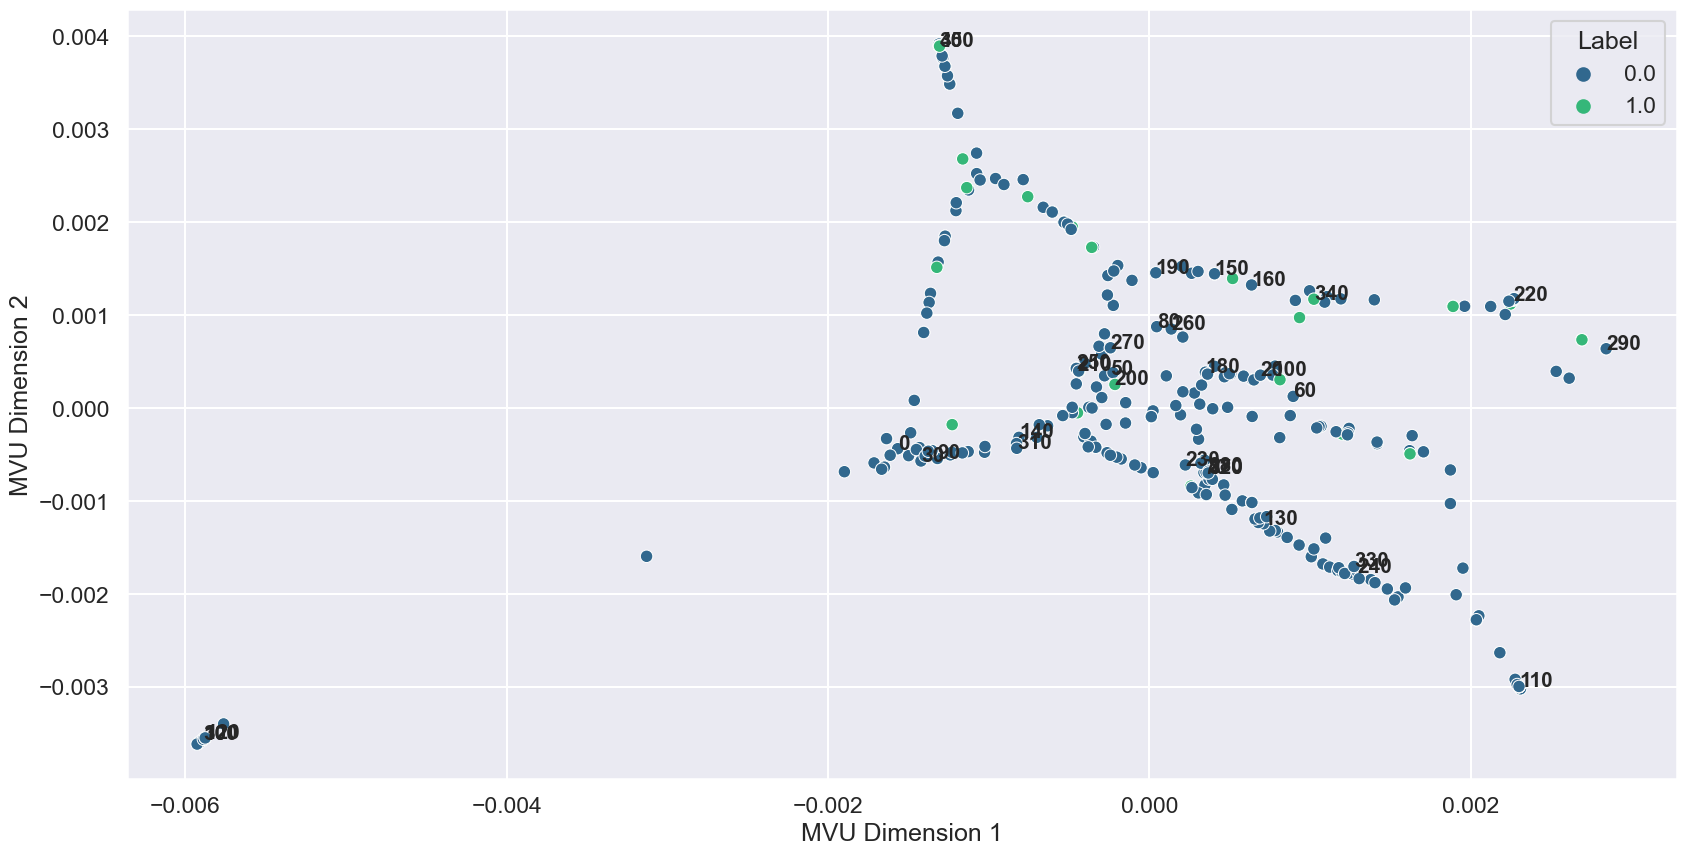

In [271]:
mvu_df = MVU_plot_1(120,4,2,X_test, y_test)

# Back to Heatmap dataset

In [272]:
# expand so that each row corresponds to 1 click:

data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded['clicks'] = 1

click_stat = data_heatmap_expanded.groupby(['click_x','click_y'])['clicks'].count().reset_index()

In [277]:
# Binning clicks in nr_of_x_bins, nr_of_y_bins:

NR_OF_X_BINS = 61
NR_OF_Y_BINS = 51

max_width = data_heatmap['display_width'].max()
max_height = data_heatmap['display_height'].max()

width_bins = np.linspace(1, max_width, NR_OF_X_BINS)
height_bins = np.linspace(1, max_height, NR_OF_Y_BINS)

width_bins_max = len(width_bins)-2 # start at 0
height_bins_max = len(height_bins)-2

data_heatmap_expanded['click_x_bin'] = pd.cut(data_heatmap_expanded['click_x'], 
                                      bins   = width_bins, 
                                      labels = False, 
                                      include_lowest = True)

data_heatmap_expanded['click_y_bin'] = pd.cut(data_heatmap_expanded['click_y'], 
                                      bins = height_bins, 
                                      labels = False, 
                                      include_lowest = True)


aggregated_clicks = data_heatmap_expanded.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')


aggregated_clicks['broken'] = 0
aggregated_clicks.loc[(aggregated_clicks.grid_id == 333519) &
            aggregated_clicks.domain.isin(cb_333519), 'broken'] = 1
aggregated_clicks.loc[(aggregated_clicks.grid_id == 333346) &
            aggregated_clicks.domain.isin(cb_333346), 'broken'] = 1

#aggregated_clicks['clicks_sum'].astype('int64');

In [278]:
print(len(aggregated_clicks[(aggregated_clicks.broken == 1) & 
                  (aggregated_clicks.grid_id == 333346)]['domain'].unique()),
     len(aggregated_clicks[(aggregated_clicks.broken == 1) & 
                  (aggregated_clicks.grid_id == 333519)]['domain'].unique()))

79 40


In [279]:
# add empty bins --> easier to generate vectors
# takes a few seconds

from itertools import product

domains_grids = data_heatmap[['domain', 'grid_id']].drop_duplicates()

aux = pd.DataFrame(list(product(range(0,width_bins_max+1), 
                                range(0,height_bins_max+1))), 
                   columns=['click_x_bin', 'click_y_bin'])

domains_grids['key'] = 1
aux['key'] = 1

expanded_set = pd.merge(domains_grids, aux, on='key').drop('key', axis=1)

data_binned = pd.merge(expanded_set, aggregated_clicks, 
                  on = ['domain', 'grid_id', 'click_x_bin', 'click_y_bin'], 
                  how = 'left').fillna(0)
data_binned['clicks_sum'] = data_binned['clicks_sum'].astype('int64')
data_binned['broken'] = data_binned['broken'].astype('int64')

data_binned

,domain,grid_id,click_x_bin,click_y_bin,clicks_sum,broken
0,ID_2660,333519,0,0,2,0
1,ID_2660,333519,0,1,1,0
2,ID_2660,333519,0,2,1,0
3,ID_2660,333519,0,3,0,0
4,ID_2660,333519,0,4,0,0
...,...,...,...,...,...,...
3635995,ID_908,333346,59,45,0,0
3635996,ID_908,333346,59,46,0,0
3635997,ID_908,333346,59,47,0,0
3635998,ID_908,333346,59,48,0,0


In [280]:
print(len(data_binned[(data_binned.grid_id == 333346) & 
            (data_binned.broken == 1)]['domain'].unique()),
      len(data_binned[(data_binned.grid_id == 333519) & 
            (data_binned.broken == 1)]['domain'].unique()))

79 40


In [281]:
cl_stat = aggregated_clicks.groupby(['click_x_bin','click_y_bin']).count().reset_index()
cl_stat = cl_stat[['click_x_bin','click_y_bin','clicks_sum']]
cl_stat['bin_prob'] = cl_stat['clicks_sum']/cl_stat['clicks_sum'].sum()

In [282]:
# aggregated clicks by grid_id:

aggregated_clicks_by_grid = aggregated_clicks.groupby([
                                'grid_id','click_x_bin','click_y_bin'
                            ]).sum('clicks_sum').reset_index()
aggregated_clicks_by_grid.drop(columns = ['broken'], inplace=True)

# Try MVU

## Grid = 333346

In [393]:
grid_id = 333346

data_binned = data_binned[data_binned['grid_id'] == grid_id]

In [394]:
pivot_df = pd.pivot_table(data_binned, values='clicks_sum', index=['domain', 'grid_id'],
                           columns=['click_x_bin', 'click_y_bin'], aggfunc='sum', fill_value=0)

pivot_df.reset_index(inplace=True)

pivot_df.columns = ['domain', 'grid_id'] + [f'clicks_sum_for_{x}_{y}' for x, y in pivot_df.columns[2:]]

In [395]:
x = pivot_df.copy()

In [396]:
x.iloc[:,2:] = (pivot_df.iloc[:,2:].transpose()/pivot_df.iloc[:,2:].sum(axis=1)).transpose()

In [397]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

features = x.columns[2:] #input.columns[1:]  # Exclude the first column, which is the index
n_components = 20
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])
pca_result = pipeline.fit_transform(x[features])
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['domain'] = x['domain']


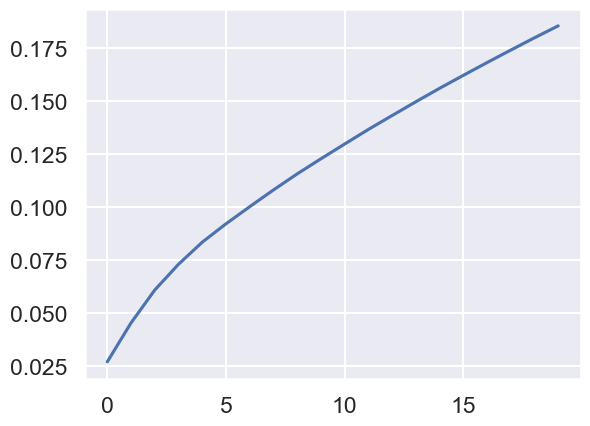

In [398]:
pca_object = pipeline.named_steps['pca']
pca_exp_var = pca_object.explained_variance_ratio_
plt.plot(np.cumsum(pca_exp_var))

In [399]:
pca_df['domain'] = x['domain']

pca_df['label'] = 0
pca_df.loc[pca_df.domain.isin(cb_333346),'label'] = 1

In [400]:
inp = pca_df.iloc[:,:n_components]

shape l (482, 120)
[[ 0.29021626 -0.00038147 -0.02123299 ... -0.00790264 -0.00529989
  -0.0174668 ]
 [-0.00038147  0.02876581 -0.00844813 ... -0.00662397  0.02626076
  -0.01065284]
 [-0.02123299 -0.00844813  0.00550492 ...  0.00180174 -0.00722452
   0.00508488]
 ...
 [-0.00790264 -0.00662397  0.00180174 ...  0.00287869 -0.00620434
   0.00273821]
 [-0.00529989  0.02626076 -0.00722452 ... -0.00620434  0.02544857
  -0.00956988]
 [-0.0174668  -0.01065284  0.00508488 ...  0.00273821 -0.00956988
   0.00580503]]


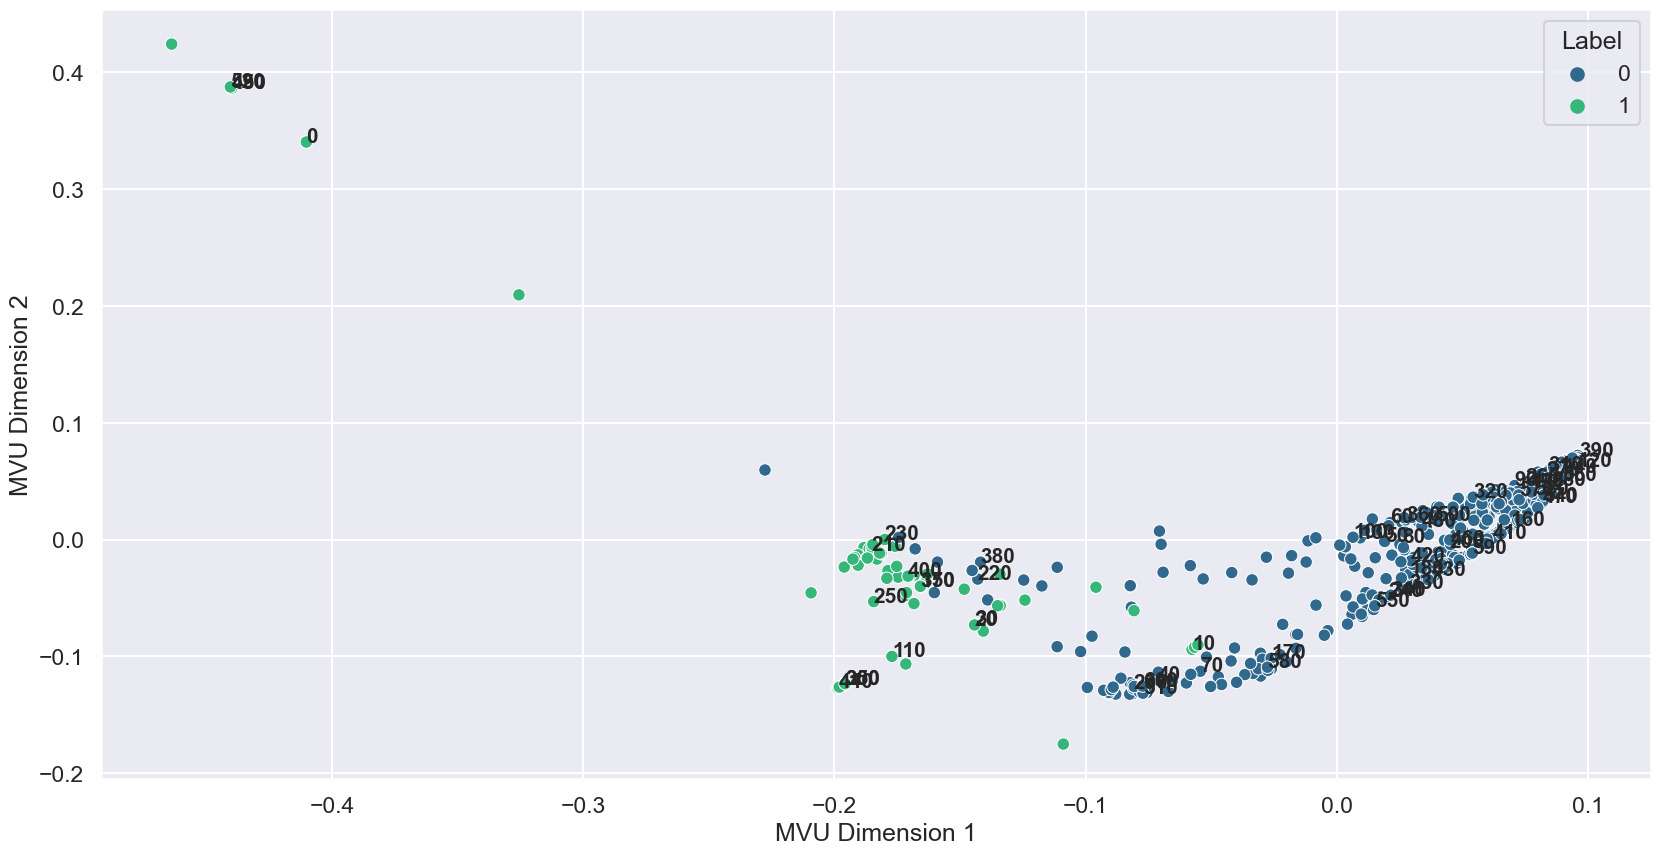

In [327]:
mvu_df = MVU_plot_1(120,4,2,inp.values, pca_df['label'])

In [347]:
X_mvu_train, X_mvu_test, y_mvu_train , y_mvu_test = train_test_split(mvu_df[['MVU Dimension 1','MVU Dimension 2']], 
                                                     mvu_df['Label'], stratify = mvu_df['Label'], 
                                                     test_size = 0.3, random_state = 1)


In [348]:
LG = LogisticRegression(solver='saga', tol=1e-2, max_iter= 200,
                           random_state=0)
distributions = dict(C= uniform(loc=0, scale=4),
                      penalty=['l2', 'l1'])

rs_cv = RandomizedSearchCV(LG, distributions, random_state=0)
rs_cv.fit(X_mvu_train, y_mvu_train)

RandomizedSearchCV(estimator=LogisticRegression(max_iter=200, random_state=0,
                                                solver='saga', tol=0.01),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1f1d29cd0>,
                                        'penalty': ['l2', 'l1']},
                   random_state=0)

In [349]:
y_mvu_pred     = rs_cv.predict(X_mvu_test)
R2_score   = rs_cv.score(X_mvu_test, y_mvu_test)
RMSE_score = confusion_matrix(y_mvu_test, y_mvu_pred)

R2_score, RMSE_score, rs_cv.best_params_ 

(0.9613259668508287,
 array([[152,   5],
        [  2,  22]]),
 {'C': 2.195254015709299, 'penalty': 'l1'})

In [350]:
X_pca_train, X_pca_test, y_pca_train , y_pca_test = train_test_split(pca_df.iloc[:,:2], 
                                                     pca_df['label'], stratify = pca_df['label'], 
                                                     test_size = 0.3, random_state = 1)

In [351]:
LG = LogisticRegression(solver='saga', tol=1e-2, max_iter= 200,
                           random_state=0)
distributions = dict(C= uniform(loc=0, scale=4),
                      penalty=['l2', 'l1'])

rs_cv = RandomizedSearchCV(LG, distributions, random_state=0)
rs_cv.fit(X_pca_train, y_pca_train)

RandomizedSearchCV(estimator=LogisticRegression(max_iter=200, random_state=0,
                                                solver='saga', tol=0.01),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1b07ff0d0>,
                                        'penalty': ['l2', 'l1']},
                   random_state=0)

In [352]:
y_pca_pred  = rs_cv.predict(X_pca_test)
R2_score   = rs_cv.score(X_pca_test, y_mvu_test)
RMSE_score = confusion_matrix(y_pca_test, y_pca_pred)

R2_score, RMSE_score, rs_cv.best_params_ 

(0.9392265193370166,
 array([[147,  10],
        [  1,  23]]),
 {'C': 2.195254015709299, 'penalty': 'l1'})

In [357]:
combine_mvu_pca = pd.concat([pca_df.iloc[:,:2],mvu_df.iloc[:,:2]], axis = 1)

In [401]:
X_pm_train, X_pm_test, y_pm_train , y_pm_test = train_test_split(combine_mvu_pca.iloc[:,:], 
                                                     pca_df['label'], stratify = pca_df['label'], 
                                                     test_size = 0.3, random_state = 1)

In [402]:
pm_scaler = StandardScaler()
X_pm_train = pm_scaler.fit_transform(X_pm_train)
X_pm_test = pm_scaler.transform(X_pm_test)

In [403]:
LG = LogisticRegression(solver='saga', tol=1e-2, max_iter= 200,
                           random_state=0)
distributions = dict(C= uniform(loc=0, scale=4),
                      penalty=['l2', 'l1'])

rs_cv = RandomizedSearchCV(LG, distributions, random_state=0)
rs_cv.fit(X_pm_train, y_pm_train)

RandomizedSearchCV(estimator=LogisticRegression(max_iter=200, random_state=0,
                                                solver='saga', tol=0.01),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1d38d67c0>,
                                        'penalty': ['l2', 'l1']},
                   random_state=0)

In [404]:
y_pm_pred  = rs_cv.predict(X_pm_test)
R2_score   = rs_cv.score(X_pm_test, y_pm_test)
RMSE_score = confusion_matrix(y_pm_test, y_pm_pred)

R2_score, RMSE_score, rs_cv.best_params_ 

(0.9834254143646409,
 array([[155,   2],
        [  1,  23]]),
 {'C': 2.195254015709299, 'penalty': 'l1'})

Adjusted Rand Index (ARI) score: 0.09004692752989629


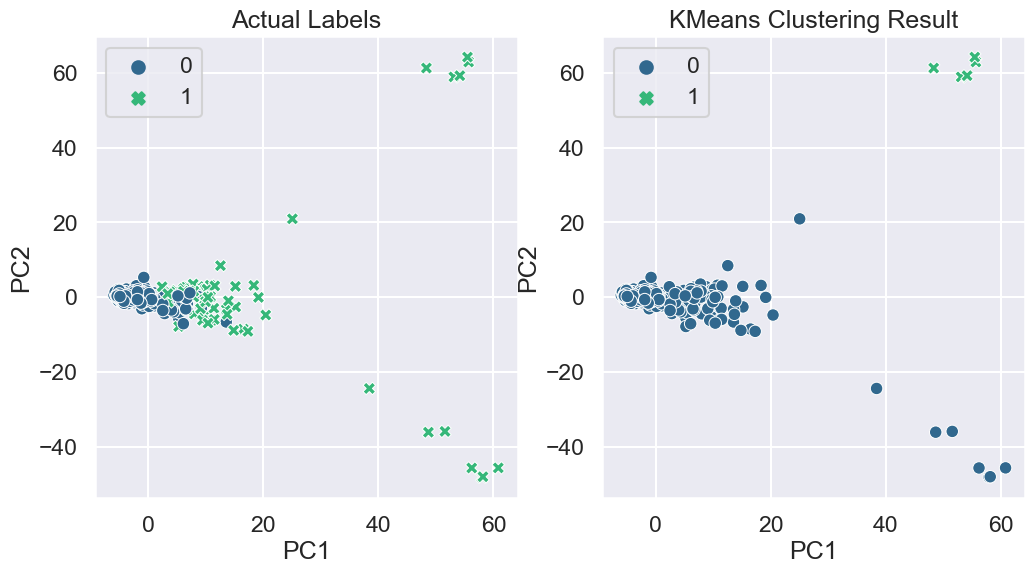

In [411]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clustersb2, random_state=42)
kmeans_labels = kmeans.fit_predict(combine_mvu_pca)

actual_labels = pca_df['label'].values

ari_score = adjusted_rand_score(actual_labels, kmeans_labels)

print(f"Adjusted Rand Index (ARI) score: {ari_score}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

sns.scatterplot(x=combine_mvu_pca.iloc[:, 0], y=combine_mvu_pca.iloc[:, 1], 
                hue=actual_labels, style=actual_labels, palette='viridis')
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=combine_mvu_pca.iloc[:, 0], y=combine_mvu_pca.iloc[:, 1], 
                hue=kmeans_labels, style=kmeans_labels, palette='viridis')
plt.title('KMeans Clustering Result')
plt.show()


Adjusted Rand Index (ARI) score: 0.5526661230589782


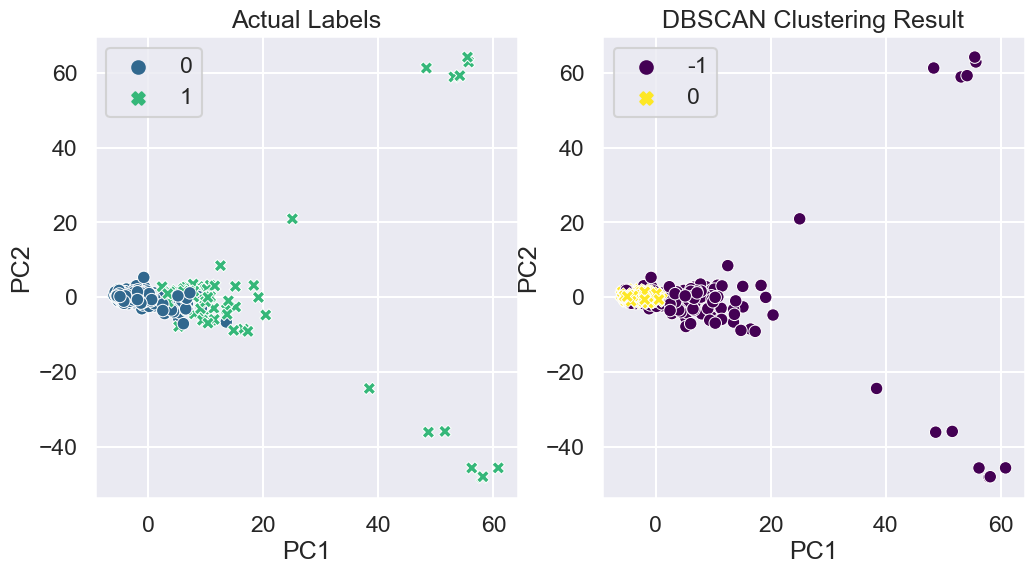

In [415]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, 
                min_samples = 5)
dbscan_labels = dbscan.fit_predict(combine_mvu_pca)

actual_labels = pca_df['label'].values
ari_score = adjusted_rand_score(actual_labels, dbscan_labels)
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

sns.set_context("talk")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=combine_mvu_pca.iloc[:, 0], y=combine_mvu_pca.iloc[:, 1], 
                hue=actual_labels, style=actual_labels, palette='viridis')
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=combine_mvu_pca.iloc[:, 0], y=combine_mvu_pca.iloc[:, 1], 
                hue=dbscan_labels, style=dbscan_labels, palette='viridis')
plt.title('DBSCAN Clustering Result')
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       523
           1       0.86      0.56      0.68        79

    accuracy                           0.93       602
   macro avg       0.90      0.77      0.82       602
weighted avg       0.93      0.93      0.92       602

Accuracy Score: 0.9302325581395349


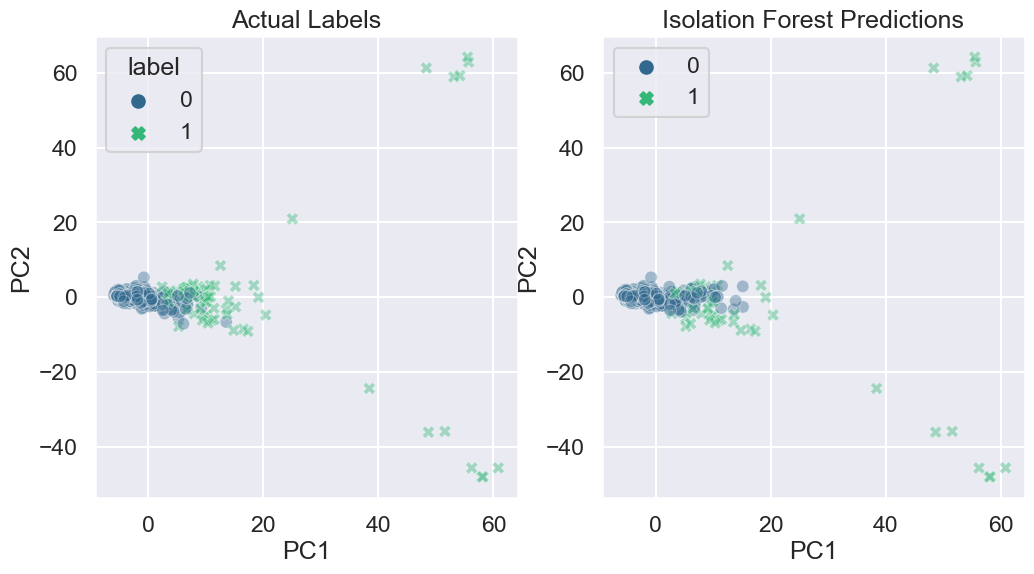

In [429]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score

isolation_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
preds = isolation_forest.fit_predict(combine_mvu_pca)

binary_preds = np.where(preds == -1, 1, 0)

print(classification_report(pca_df['label'], binary_preds))
print(f"Accuracy Score: {accuracy_score(pca_df['label'], binary_preds)}")

plt.figure(figsize=(12, 6))
sns.set_context("talk")

plt.subplot(1, 2, 1)
sns.scatterplot(x=combine_mvu_pca.iloc[:, 0], y=combine_mvu_pca.iloc[:, 1], 
                hue=pca_df['label'], style=pca_df['label'], palette='viridis', alpha = 0.4)
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=combine_mvu_pca.iloc[:, 0], y=combine_mvu_pca.iloc[:, 1], 
                hue=binary_preds, style=binary_preds, palette='viridis', alpha = 0.4)
plt.title('Isolation Forest Predictions')
plt.show()



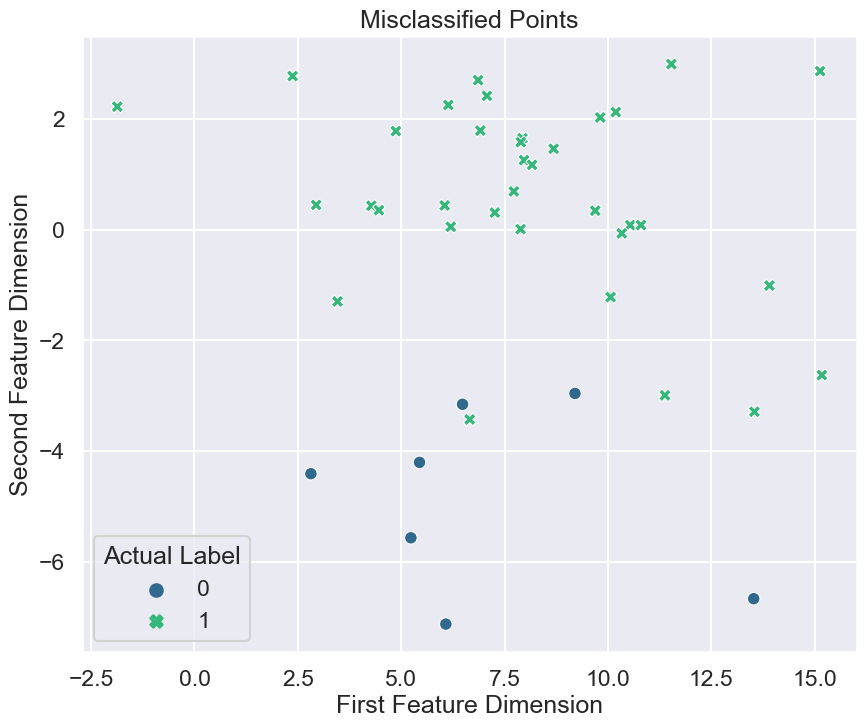

In [430]:
misclassified = pca_df['label'] != binary_preds

misclassified_points = combine_mvu_pca[misclassified]

misclassified_labels = pca_df['label'][misclassified]

plt.figure(figsize=(10, 8))
sns.scatterplot(x=misclassified_points.iloc[:, 0], y=misclassified_points.iloc[:, 1], 
                hue=misclassified_labels, style=misclassified_labels, palette='viridis')
plt.title('Misclassified Points')
plt.xlabel('First Feature Dimension')
plt.ylabel('Second Feature Dimension')
plt.legend(title='Actual Label')
plt.show()

## Grid = 333346

In [431]:
# add empty bins --> easier to generate vectors
# takes a few seconds

from itertools import product

domains_grids = data_heatmap[['domain', 'grid_id']].drop_duplicates()

aux = pd.DataFrame(list(product(range(0,width_bins_max+1), 
                                range(0,height_bins_max+1))), 
                   columns=['click_x_bin', 'click_y_bin'])

domains_grids['key'] = 1
aux['key'] = 1

expanded_set = pd.merge(domains_grids, aux, on='key').drop('key', axis=1)

data_binned = pd.merge(expanded_set, aggregated_clicks, 
                  on = ['domain', 'grid_id', 'click_x_bin', 'click_y_bin'], 
                  how = 'left').fillna(0)
data_binned['clicks_sum'] = data_binned['clicks_sum'].astype('int64')
data_binned['broken'] = data_binned['broken'].astype('int64')

data_binned

,domain,grid_id,click_x_bin,click_y_bin,clicks_sum,broken
0,ID_2660,333519,0,0,2,0
1,ID_2660,333519,0,1,1,0
2,ID_2660,333519,0,2,1,0
3,ID_2660,333519,0,3,0,0
4,ID_2660,333519,0,4,0,0
...,...,...,...,...,...,...
3635995,ID_908,333346,59,45,0,0
3635996,ID_908,333346,59,46,0,0
3635997,ID_908,333346,59,47,0,0
3635998,ID_908,333346,59,48,0,0


In [432]:
grid_id = 333519

data_binned = data_binned[data_binned['grid_id'] == grid_id]

In [433]:
pivot_df = pd.pivot_table(data_binned, values='clicks_sum', index=['domain', 'grid_id'],
                           columns=['click_x_bin', 'click_y_bin'], aggfunc='sum', fill_value=0)

pivot_df.reset_index(inplace=True)

pivot_df.columns = ['domain', 'grid_id'] + [f'clicks_sum_for_{x}_{y}' for x, y in pivot_df.columns[2:]]

In [434]:
x = pivot_df.copy()

In [435]:
x.iloc[:,2:] = (pivot_df.iloc[:,2:].transpose()/pivot_df.iloc[:,2:].sum(axis=1)).transpose()

In [436]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

features = x.columns[2:] #input.columns[1:]  # Exclude the first column, which is the index
n_components = 20
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])
pca_result = pipeline.fit_transform(x[features])
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['domain'] = x['domain']


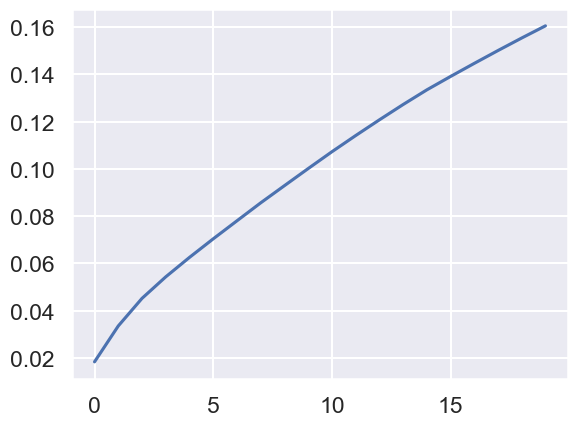

In [437]:
pca_object = pipeline.named_steps['pca']
pca_exp_var = pca_object.explained_variance_ratio_
plt.plot(np.cumsum(pca_exp_var))

In [438]:
pca_df['domain'] = x['domain']

pca_df['label'] = 0
pca_df.loc[pca_df.domain.isin(cb_333346),'label'] = 1

In [439]:
inp = pca_df.iloc[:,:n_components]

In [453]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,domain,label
0,-1.911236,0.968730,0.073594,0.353577,0.663937,-0.520842,0.281410,-0.939753,-1.074172,-0.736532,...,1.856133,-0.906862,1.464849,1.526059,1.417777,1.023300,-0.186673,-0.059225,ID_1000,0
1,-1.633056,-0.004095,-1.488928,-1.077216,-0.309560,1.274673,-0.566791,-0.789269,-0.935314,-0.733235,...,0.970899,-2.719656,-1.020422,-2.101760,-3.687939,0.174339,0.075909,0.464805,ID_1010,0
2,1.296101,-13.064209,-11.664009,0.695947,2.522872,-1.946642,-0.891995,-0.257390,2.923082,-0.762670,...,-1.870949,-3.781258,2.590504,-0.177398,2.748186,0.001487,-3.021283,-1.401249,ID_1021,0
3,-3.087212,4.188494,1.158415,0.472367,-0.242244,-1.045623,0.298134,-0.268498,0.502740,1.035425,...,-0.034328,0.555930,1.457141,0.260783,0.280440,-0.186664,-0.429850,1.148095,ID_1024,0
4,-3.171394,6.077727,1.279608,-0.919798,0.774646,-0.013228,0.005107,-1.082933,-1.735718,-0.860774,...,-1.186748,-0.626262,-0.558677,-2.346587,-1.566404,-1.861210,2.961061,-1.623575,ID_1055,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,-3.636956,5.217645,0.503157,-0.824426,-0.154175,-0.331370,1.386201,-1.476430,-0.568631,0.772701,...,-0.150828,-0.831344,0.640919,0.593810,1.078331,-0.542817,-1.773035,0.570363,ID_978,0
606,5.256328,-21.374558,-15.085102,-1.250823,3.033062,1.364032,-1.652822,0.747930,4.263295,-2.721147,...,-3.659008,-0.541964,-0.750710,1.352622,-5.524946,-1.257289,3.918832,-11.106653,ID_990,0
607,-2.177196,0.701351,-3.615379,0.877120,-1.756649,-1.026622,1.084488,-1.926556,2.247925,-1.294104,...,1.286331,-0.034086,-1.599613,-1.468064,0.952031,-1.399360,0.154790,-1.171390,ID_995,0
608,0.843952,-6.826539,-6.499769,1.256327,1.573153,0.200970,-0.398771,0.463175,0.789520,0.574180,...,-0.738197,-0.866083,0.384675,-0.128879,-0.439314,0.629933,0.622879,-1.087460,ID_996,0


shape l (490, 120)
[[ 0.0026064   0.00133097 -0.0072857  ...  0.00031389 -0.00508587
   0.00150506]
 [ 0.00133097  0.00142223 -0.00568097 ...  0.00025289 -0.00349394
   0.00105369]
 [-0.0072857  -0.00568097  0.05777    ... -0.00209005  0.0232058
  -0.00748231]
 ...
 [ 0.00031389  0.00025289 -0.00209005 ...  0.00064349 -0.00083729
   0.00027845]
 [-0.00508587 -0.00349394  0.0232058  ... -0.00083729  0.01445723
  -0.0041887 ]
 [ 0.00150506  0.00105369 -0.00748231 ...  0.00027845 -0.0041887
   0.00189155]]


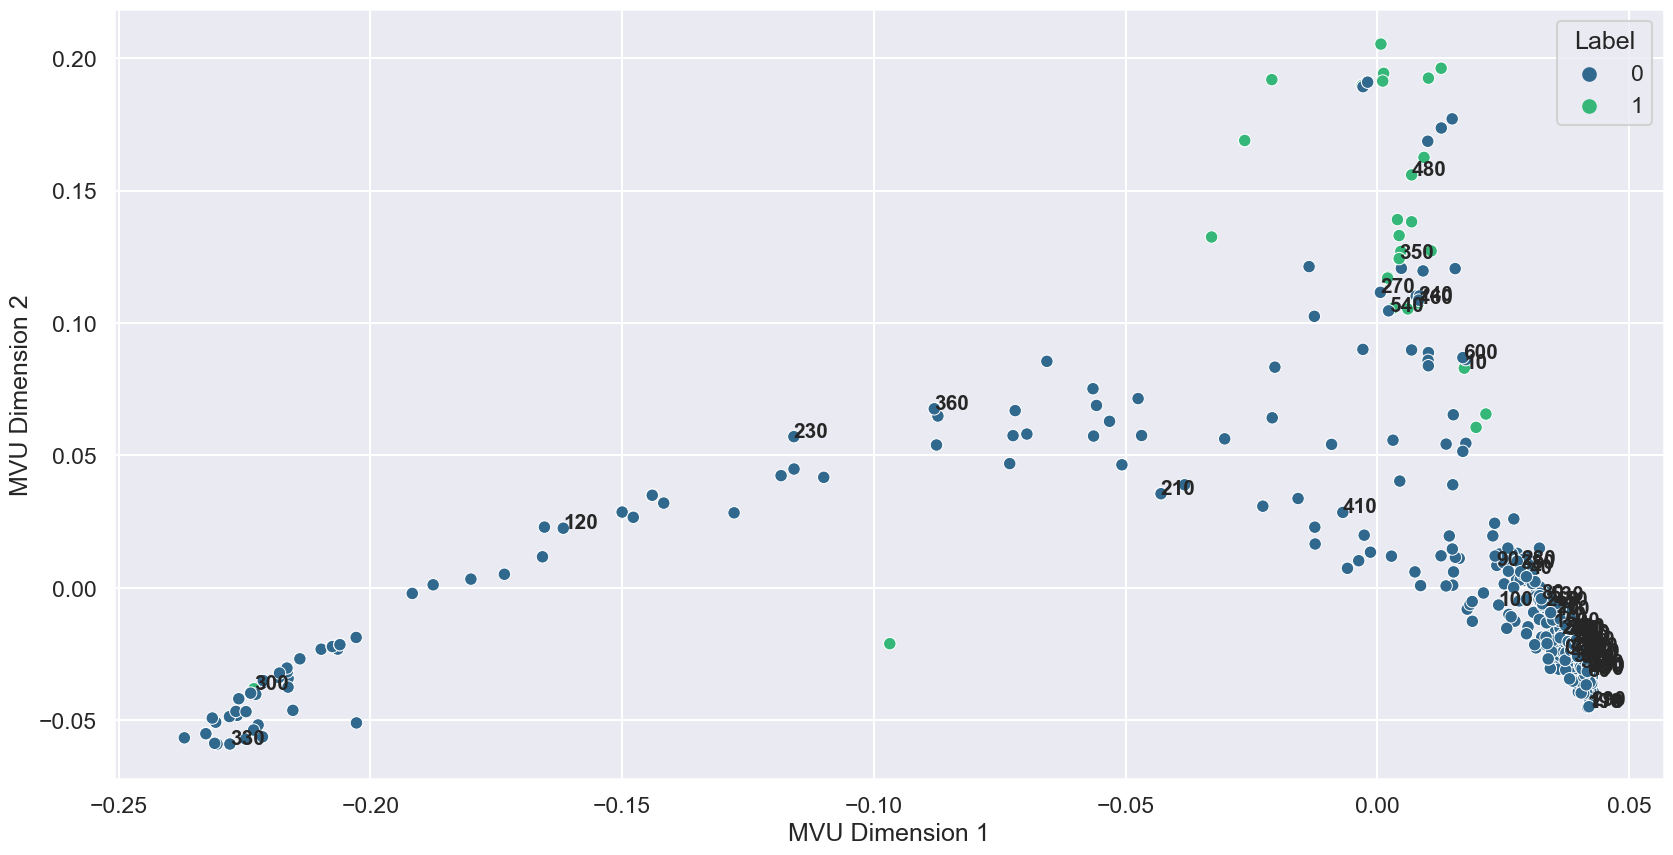

In [440]:
mvu_df = MVU_plot_1(120,4,2,inp.values, pca_df['label'])

In [441]:
X_mvu_train, X_mvu_test, y_mvu_train , y_mvu_test = train_test_split(mvu_df[['MVU Dimension 1','MVU Dimension 2']], 
                                                     mvu_df['Label'], stratify = mvu_df['Label'], 
                                                     test_size = 0.3, random_state = 1)


In [442]:
LG = LogisticRegression(solver='saga', tol=1e-2, max_iter= 200,
                           random_state=0)
distributions = dict(C= uniform(loc=0, scale=4),
                      penalty=['l2', 'l1'])

rs_cv = RandomizedSearchCV(LG, distributions, random_state=0)
rs_cv.fit(X_mvu_train, y_mvu_train)

RandomizedSearchCV(estimator=LogisticRegression(max_iter=200, random_state=0,
                                                solver='saga', tol=0.01),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1b0325b80>,
                                        'penalty': ['l2', 'l1']},
                   random_state=0)

In [443]:
y_mvu_pred = rs_cv.predict(X_mvu_test)
R2_score   = rs_cv.score(X_mvu_test, y_mvu_test)
RMSE_score = confusion_matrix(y_mvu_test, y_mvu_pred)

R2_score, RMSE_score, rs_cv.best_params_ 

(0.9562841530054644,
 array([[172,   1],
        [  7,   3]]),
 {'C': 3.3770629943240693, 'penalty': 'l1'})

In [444]:
X_pca_train, X_pca_test, y_pca_train , y_pca_test = train_test_split(pca_df.iloc[:,:2], 
                                                     pca_df['label'], stratify = pca_df['label'], 
                                                     test_size = 0.3, random_state = 1)

In [445]:
LG = LogisticRegression(solver='saga', tol=1e-2, max_iter= 200,
                           random_state=0)
distributions = dict(C= uniform(loc=0, scale=4),
                      penalty=['l2', 'l1'])

rs_cv = RandomizedSearchCV(LG, distributions, random_state=0)
rs_cv.fit(X_pca_train, y_pca_train)

RandomizedSearchCV(estimator=LogisticRegression(max_iter=200, random_state=0,
                                                solver='saga', tol=0.01),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa0d1be2670>,
                                        'penalty': ['l2', 'l1']},
                   random_state=0)

In [446]:
y_pca_pred  = rs_cv.predict(X_pca_test)
R2_score   = rs_cv.score(X_pca_test, y_mvu_test)
RMSE_score = confusion_matrix(y_pca_test, y_pca_pred)

R2_score, RMSE_score, rs_cv.best_params_ 

(0.9617486338797814,
 array([[168,   5],
        [  2,   8]]),
 {'C': 2.195254015709299, 'penalty': 'l1'})

In [447]:
combine_mvu_pca = pd.concat([pca_df.iloc[:,:2],mvu_df.iloc[:,:2]], axis = 1)

In [448]:
X_pm_train, X_pm_test, y_pm_train , y_pm_test = train_test_split(combine_mvu_pca.iloc[:,:], 
                                                     pca_df['label'], stratify = pca_df['label'], 
                                                     test_size = 0.3, random_state = 1)

In [449]:
pm_scaler = StandardScaler()
X_pm_train = pm_scaler.fit_transform(X_pm_train)
X_pm_test = pm_scaler.transform(X_pm_test)

In [450]:
LG = LogisticRegression(solver='saga', tol=1e-2, max_iter= 200,
                           random_state=0)
distributions = dict(C= uniform(loc=0, scale=4),
                      penalty=['l2', 'l1'])

rs_cv = RandomizedSearchCV(LG, distributions, random_state=0)
rs_cv.fit(X_pm_train, y_pm_train)

RandomizedSearchCV(estimator=LogisticRegression(max_iter=200, random_state=0,
                                                solver='saga', tol=0.01),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa1c01aeca0>,
                                        'penalty': ['l2', 'l1']},
                   random_state=0)

In [451]:
y_pm_pred  = rs_cv.predict(X_pm_test)
R2_score   = rs_cv.score(X_pm_test, y_pm_test)
RMSE_score = confusion_matrix(y_pm_test, y_pm_pred)

R2_score, RMSE_score, rs_cv.best_params_ 

(0.9617486338797814,
 array([[172,   1],
        [  6,   4]]),
 {'C': 2.195254015709299, 'penalty': 'l1'})

Adjusted Rand Index (ARI) score: 0.09967017221376882


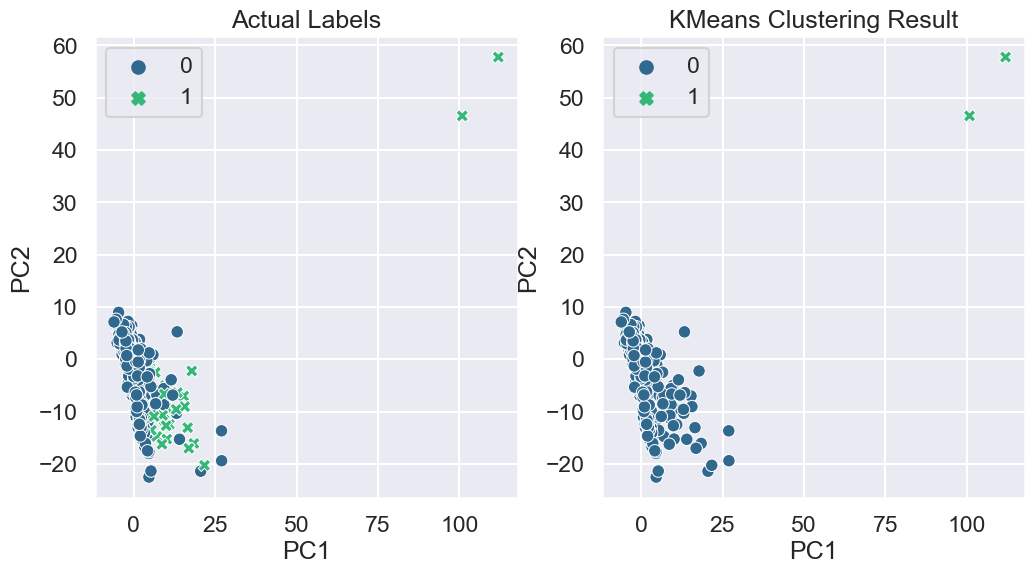

In [454]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters = 2, random_state=42)
kmeans_labels = kmeans.fit_predict(combine_mvu_pca)

actual_labels = pca_df['label'].values

ari_score = adjusted_rand_score(actual_labels, kmeans_labels)

print(f"Adjusted Rand Index (ARI) score: {ari_score}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

sns.scatterplot(x=combine_mvu_pca.iloc[:, 0], y=combine_mvu_pca.iloc[:, 1], 
                hue=actual_labels, style=actual_labels, palette='viridis')
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=combine_mvu_pca.iloc[:, 0], y=combine_mvu_pca.iloc[:, 1], 
                hue=kmeans_labels, style=kmeans_labels, palette='viridis')
plt.title('KMeans Clustering Result')
plt.show()


Adjusted Rand Index (ARI) score: -0.02787726674361338


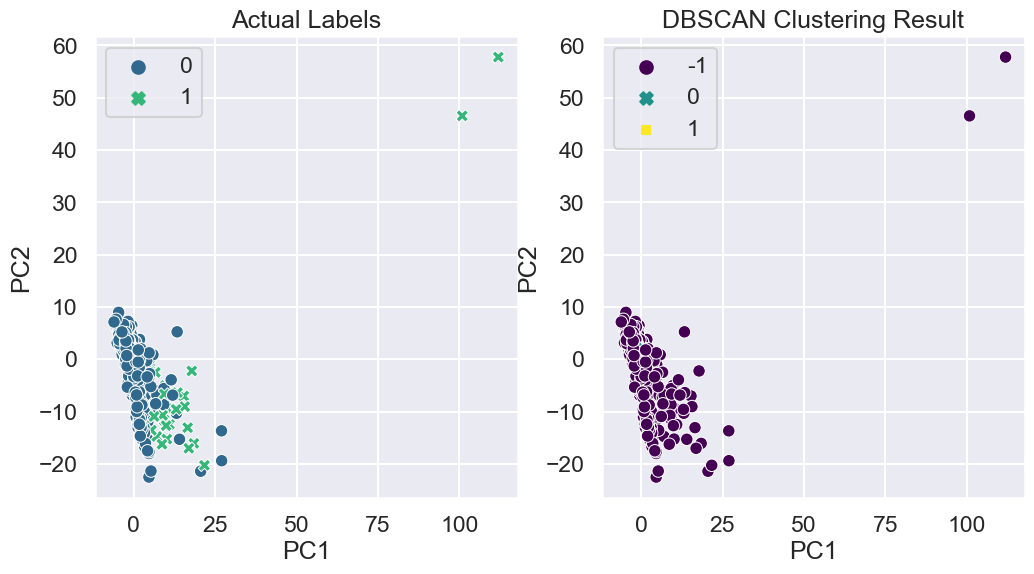

In [459]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.1, 
                min_samples = 5)
dbscan_labels = dbscan.fit_predict(combine_mvu_pca)

actual_labels = pca_df['label'].values
ari_score = adjusted_rand_score(actual_labels, dbscan_labels)
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

sns.set_context("talk")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=combine_mvu_pca.iloc[:, 0], y=combine_mvu_pca.iloc[:, 1], 
                hue=actual_labels, style=actual_labels, palette='viridis')
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=combine_mvu_pca.iloc[:, 0], y=combine_mvu_pca.iloc[:, 1], 
                hue=dbscan_labels, style=dbscan_labels, palette='viridis')
plt.title('DBSCAN Clustering Result')
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.77      0.87       576
           1       0.19      0.88      0.31        34

    accuracy                           0.78       610
   macro avg       0.59      0.83      0.59       610
weighted avg       0.95      0.78      0.84       610

Accuracy Score: 0.7770491803278688


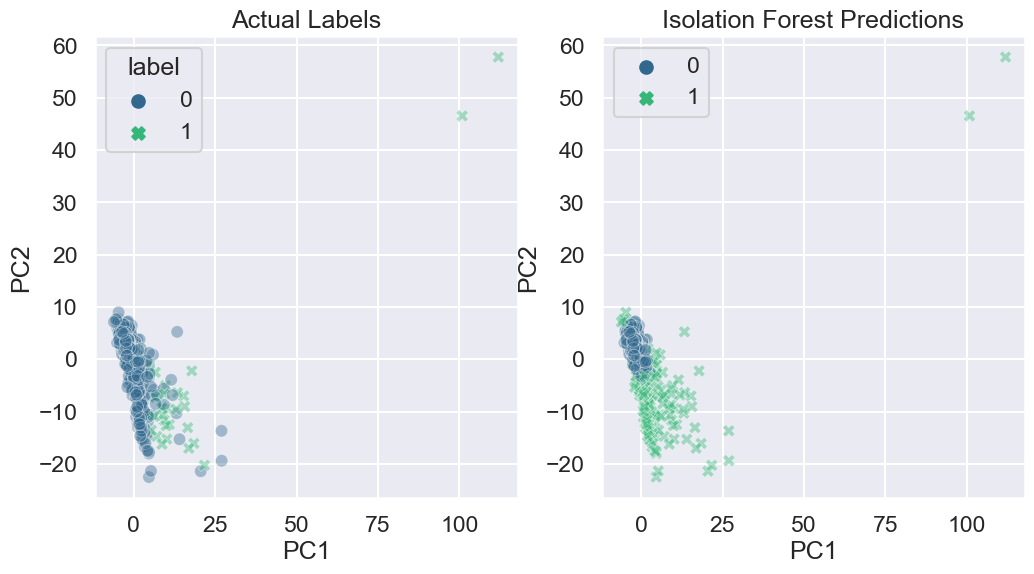

In [460]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score

isolation_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
preds = isolation_forest.fit_predict(combine_mvu_pca)

binary_preds = np.where(preds == -1, 1, 0)

print(classification_report(pca_df['label'], binary_preds))
print(f"Accuracy Score: {accuracy_score(pca_df['label'], binary_preds)}")

plt.figure(figsize=(12, 6))
sns.set_context("talk")

plt.subplot(1, 2, 1)
sns.scatterplot(x=combine_mvu_pca.iloc[:, 0], y=combine_mvu_pca.iloc[:, 1], 
                hue=pca_df['label'], style=pca_df['label'], palette='viridis', alpha = 0.4)
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=combine_mvu_pca.iloc[:, 0], y=combine_mvu_pca.iloc[:, 1], 
                hue=binary_preds, style=binary_preds, palette='viridis', alpha = 0.4)
plt.title('Isolation Forest Predictions')
plt.show()



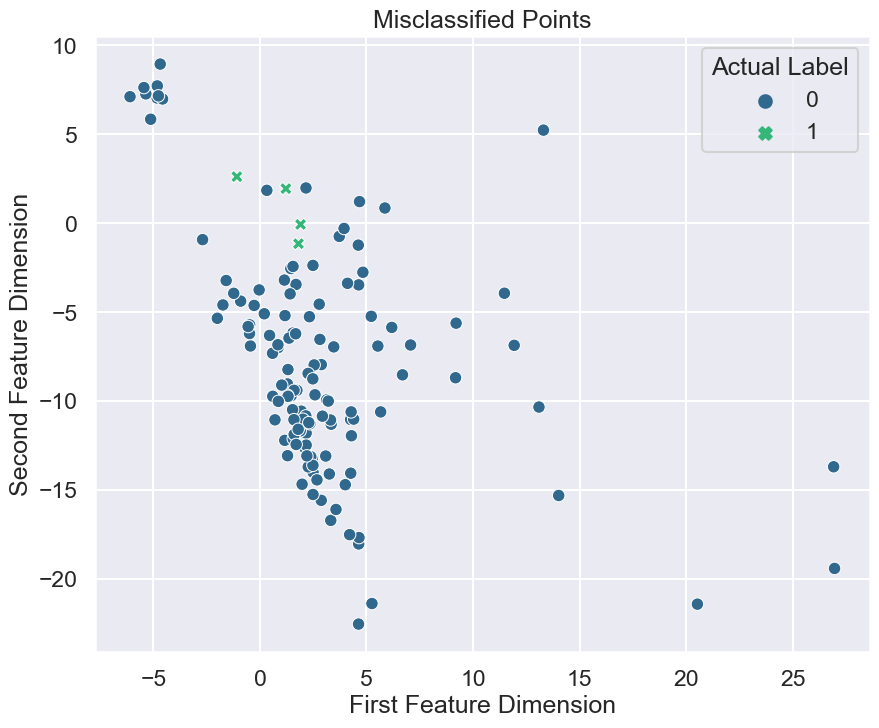

In [461]:
misclassified = pca_df['label'] != binary_preds

misclassified_points = combine_mvu_pca[misclassified]

misclassified_labels = pca_df['label'][misclassified]

plt.figure(figsize=(10, 8))
sns.scatterplot(x=misclassified_points.iloc[:, 0], y=misclassified_points.iloc[:, 1], 
                hue=misclassified_labels, style=misclassified_labels, palette='viridis')
plt.title('Misclassified Points')
plt.xlabel('First Feature Dimension')
plt.ylabel('Second Feature Dimension')
plt.legend(title='Actual Label')
plt.show()

In [ ]:
mvu_df = MVU_plot_1(120,4,2,inp.values, pca_df['label'])

# Some Bootstrap functions

In [15]:
# def weighted_bootstrap_resample(data, weights, n_bootstraps=1000):
#     boot_means = []
#     for _ in range(n_bootstraps):
#         indices = np.random.choice(data.index, 
#                                    size=len(data), 
#                                    replace=True, 
#                                    p=weights)
#         boot_sample = data.loc[indices]
#         boot_means.append(np.mean(boot_sample['clicks_sum']))
#     return np.mean(boot_means), np.percentile(boot_means, [2.5, 97.5])

def weighted_bootstrap_resample(data, drawing_distro, emp_distro, size, n_bootstraps=1000):
    tot_log_proba = 0
    for _ in range(n_bootstraps):
        indices = np.random.choice(data.index, 
                                   size=size, 
                                   replace=True, 
                                   p=data[drawing_distro])
        log_proba = np.log(data.loc[indices][emp_distro]).sum()
        tot_log_proba += log_proba
    return tot_log_proba/n_bootstraps #boots[['click_x_bin','click_y_bin', 'boot']]

## Chi-Squared:

In [16]:
from scipy.stats import chisquare

def Chi_squared_test(aggregated_clicks, aggregated_clicks_by_grid, ID, GRID_ID):
    observed = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                                 (aggregated_clicks.domain == ID)]

    click_stat_grid = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == GRID_ID]
    click_stat_grid = click_stat_grid.copy()
    click_stat_grid['bin_prob'] = click_stat_grid['clicks_sum']/click_stat_grid['clicks_sum'].sum()

    observed_freq = observed.merge(click_stat_grid, 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    observed_freq = observed[['click_x_bin',
                              'click_y_bin',
                              'clicks_sum']].merge(click_stat_grid[['click_x_bin',
                                                    'click_y_bin',
                                                    'bin_prob']], 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    total_observations = observed_freq['clicks_sum'].sum()
    observed_freq['Expected'] = observed_freq['bin_prob'] * total_observations

    # Perform Chi-square test
    chi_square_stat, p_value = chisquare(f_obs = observed_freq['clicks_sum'], 
                                         f_exp = observed_freq['Expected'])
    
    return chi_square_stat, p_value, total_observations

# Combine both datasets

In [486]:
domains_grids = data_heatmap[['domain', 'grid_id']].drop_duplicates()

aux = pd.DataFrame(list(product(range(0,width_bins_max+1), 
                                range(0,height_bins_max+1))), 
                   columns=['click_x_bin', 'click_y_bin'])

domains_grids['key'] = 1
aux['key'] = 1

expanded_set = pd.merge(domains_grids, aux, on='key').drop('key', axis=1)

data_binned = pd.merge(expanded_set, aggregated_clicks, 
                  on = ['domain', 'grid_id', 'click_x_bin', 'click_y_bin'], 
                  how = 'left').fillna(0)
data_binned['clicks_sum'] = data_binned['clicks_sum'].astype('int64')
data_binned['broken'] = data_binned['broken'].astype('int64')

In [485]:
# pd.merge(data_metrics, 
#          data_binned, 
#          how = 'right', 
#          on = ['domain','grid_id']).drop(columns = ['webview_height','Unnamed: 0',
#          'webview_width', 'broken_x'])

In [496]:
grid_id = 333519

data_binned = data_binned[data_binned['grid_id'] == grid_id]

pivot_df = pd.pivot_table(data_binned, values='clicks_sum', index=['domain', 'grid_id'],
                           columns=['click_x_bin', 'click_y_bin'], aggfunc='sum', fill_value=0)
pivot_df.reset_index(inplace=True)
pivot_df.columns = ['domain', 'grid_id'] + [f'clicks_sum_for_{x}_{y}' for x, y in pivot_df.columns[2:]]

x = pivot_df.copy()
x.iloc[:,2:] = (pivot_df.iloc[:,2:].transpose()/pivot_df.iloc[:,2:].sum(axis=1)).transpose()

In [513]:
features = x.columns[2:]
n_components = 20
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])
hm_pca_result = pipeline.fit_transform(x[features])
hm_pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
hm_pca_df['domain'] = x['domain']

In [514]:
hm_pca_df['domain'] = x['domain']

hm_pca_df['label'] = 0
hm_pca_df.loc[pca_df.domain.isin(cb_333346),'label'] = 1

In [506]:
#data_metrics = data_metrics.drop(data_metrics.loc[data_metrics.broken.isna()].index)
# y_dm = data_metrics['broken']
# X_dm = data_metrics.drop(columns = ['grid_id','domain','Unnamed: 0','webview_height',
#                                     'webview_width','broken']).ffill(0)
# dom_train, dom_test = train_test_split(data_metrics[data_metrics.grid_id == grid_id]['domain'], 
#                                        stratify = data_metrics[data_metrics.grid_id == grid_id]['broken'], 
#                                        test_size = 0.3, random_state = 1)


In [515]:
# dm_X = data_metrics.drop(columns = ['grid_id','domain','Unnamed: 0','webview_height',
#                                      'webview_width','broken']).ffill(0)

In [545]:
dm = data_metrics[data_metrics.grid_id == grid_id].drop(columns = 'Unnamed: 0').ffill(0)

In [546]:
scaler  = StandardScaler()
dm_scaled = scaler.fit_transform(dm[dm.columns[4:-1]])
#dm_scaled['domain'] = dm['domain']

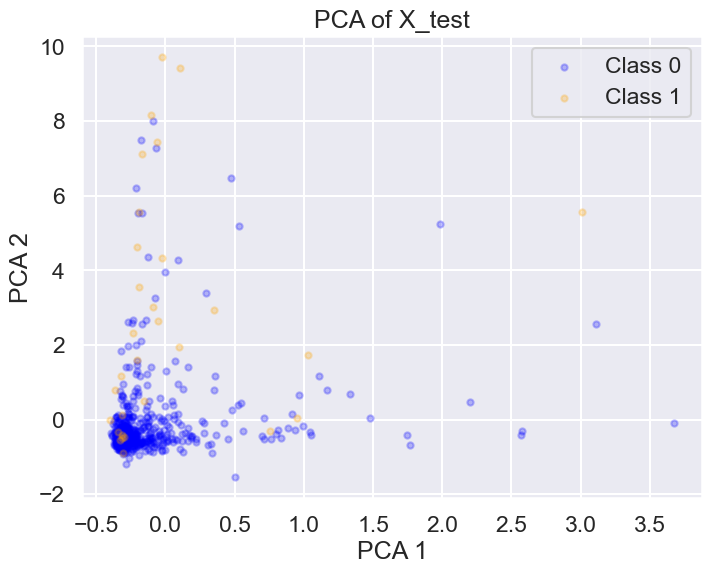

Explained variance by PCA component: [0.41737515 0.22498701]
Total variance explained by 2 components: 64.24%


In [569]:
pca   = PCA(n_components = 2)
dm_pca = pca.fit_transform(dm_scaled)

X_pca_red = dm_pca[dm_pca[:, 0] < 4]
y_pca_red = dm['broken'].values[dm_pca[:, 0] < 4]

plt.figure(figsize=(8, 6))
for label, color in zip([0, 1], ['blue', 'orange']):
    plt.scatter(X_pca_red[y_pca_red == label, 0], 
                X_pca_red[y_pca_red == label, 1], 
                c = color, 
                label = f'Class {label}', 
                alpha = 0.25,
                s = 20)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of X_test')
plt.legend()
plt.show()

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PCA component: {explained_variance}")
print(f"Total variance explained by 2 components: {np.sum(explained_variance) * 100:.2f}%")

# plt.figure(figsize=(6, 4))
# plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, 
#         align='center', label='Individual explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component')
# plt.title('Explained Variance by PCA Components')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [602]:
hm_pca_df_m = pd.merge(hm_pca_df, dm, on = 'domain').iloc[:,:20]
hm_pca_df_y['label'] = pd.merge(hm_pca_df, dm, on = 'domain').iloc[:,-1]

In [603]:
dm_pca_df = pd.DataFrame(data = dm_pca, columns = ['dm_pca1', 'dm_pca2'])

In [604]:
combined_pcas = pd.concat([hm_pca_df_m,dm_pca_df], axis = 1)

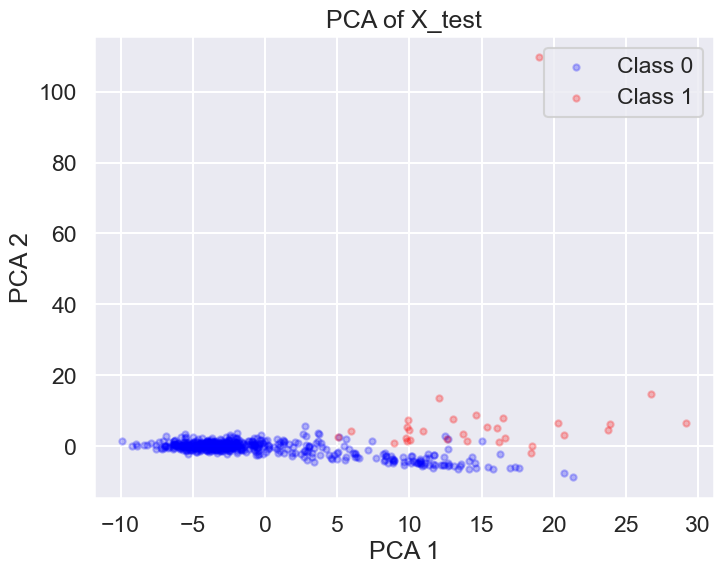

Explained variance by PCA component: [0.41737515 0.22498701]
Total variance explained by 2 components: 64.24%


In [606]:
combined_pca2x2 = combined_pcas.iloc[:,[0,1,-2,-1]]
pca_2x2   = PCA(n_components = 2)
pca_2x2_trsf = pca_2x2.fit_transform(combined_pca2x2)

plt.figure(figsize=(8, 6))
for label, color in zip([0, 1], ['blue', 'red']):
    plt.scatter(pca_2x2_trsf[hm_pca_df_y['label'] == label, 0], 
                pca_2x2_trsf[hm_pca_df_y['label'] == label, 1], 
                c = color, 
                label = f'Class {label}', 
                alpha = 0.25,
                s = 20)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of X_test')
plt.legend()
plt.show()

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PCA component: {explained_variance}")
print(f"Total variance explained by 2 components: {np.sum(explained_variance) * 100:.2f}%")

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94       559
         1.0       0.32      1.00      0.48        30

    accuracy                           0.89       589
   macro avg       0.66      0.94      0.71       589
weighted avg       0.97      0.89      0.91       589

Accuracy Score: 0.8896434634974533


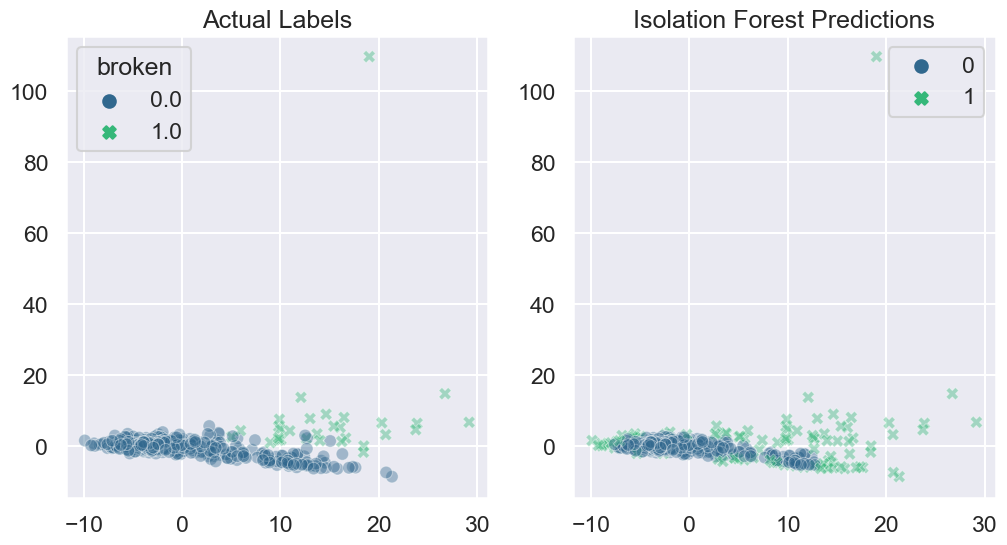

In [617]:
isolation_forest = IsolationForest(n_estimators=100, 
                                   contamination='auto', random_state=42)
preds = isolation_forest.fit_predict(pca_2x2_trsf)

binary_preds = np.where(preds == -1, 1, 0)

print(classification_report(hm_pca_df_y['label'], binary_preds))
print(f"Accuracy Score: {accuracy_score(hm_pca_df_y['label'], binary_preds)}")

plt.figure(figsize=(12, 6))
sns.set_context("talk")

plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_2x2_trsf[:, 0], y=pca_2x2_trsf[:, 1], 
                hue=hm_pca_df_y['label'], style=hm_pca_df_y['label'], palette='viridis', alpha = 0.4)
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=pca_2x2_trsf[:, 0], y=pca_2x2_trsf[:, 1], 
                hue=binary_preds, style=binary_preds, palette='viridis', alpha = 0.4)
plt.title('Isolation Forest Predictions')
plt.show()

Adjusted Rand Index (ARI) score: 0.5879800902404237


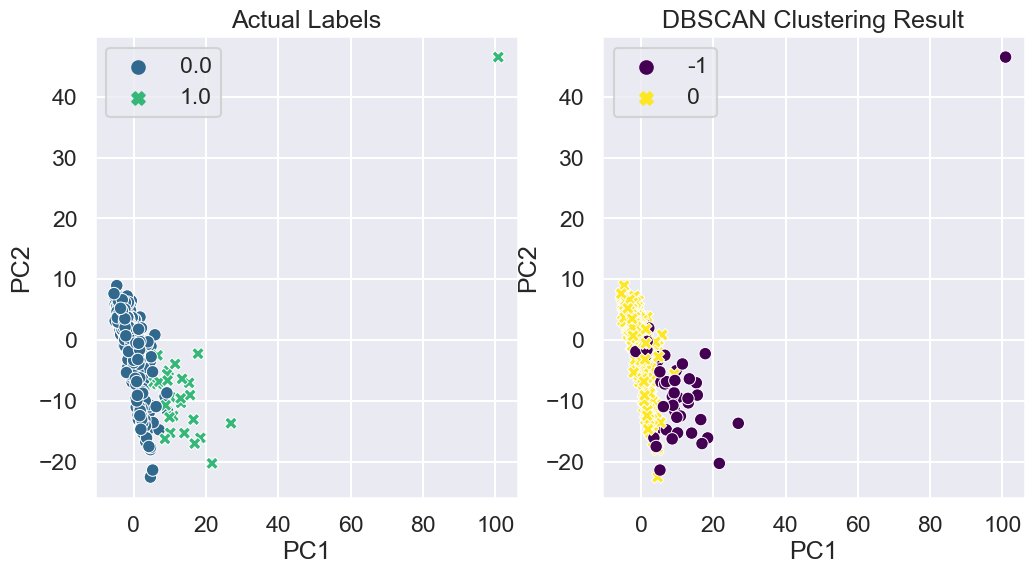

In [639]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 10, 
                min_samples = 5)
dbscan_labels = dbscan.fit_predict(combined_pcas)

actual_labels = hm_pca_df_y['label'].values
ari_score = adjusted_rand_score(actual_labels, dbscan_labels)
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

sns.set_context("talk")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=combined_pcas.iloc[:, 0], y=combined_pcas.iloc[:, 1], 
                hue=actual_labels, style=actual_labels, palette='viridis')
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=combined_pcas.iloc[:, 0], y=combined_pcas.iloc[:, 1], 
                hue=dbscan_labels, style=dbscan_labels, palette='viridis')
plt.title('DBSCAN Clustering Result')
plt.show()

Adjusted Rand Index (ARI) score: 0.23364668816739148


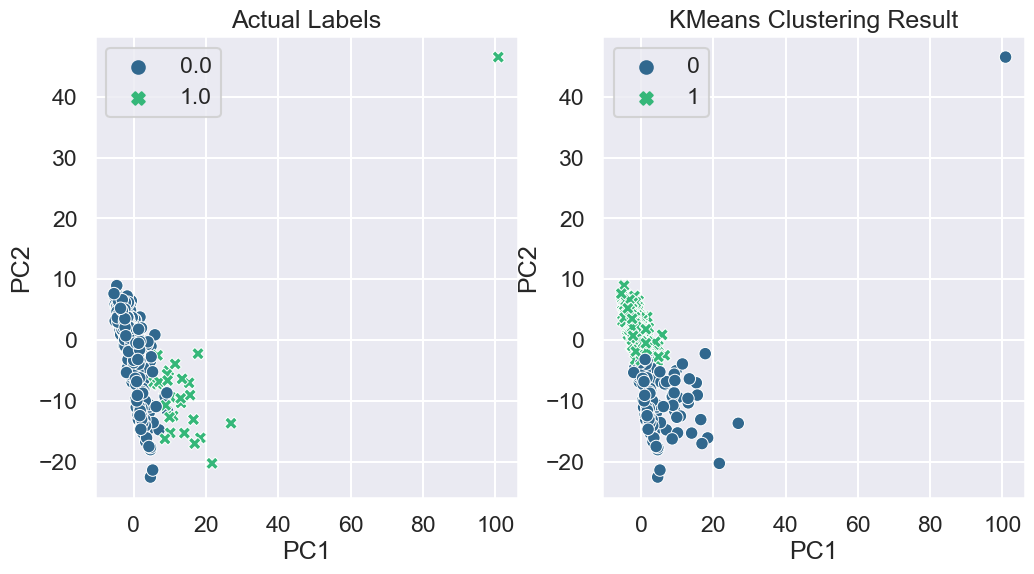

In [640]:
kmeans = KMeans(n_clusters = 2, random_state=42)
kmeans_labels = kmeans.fit_predict(combined_pcas)

actual_labels = hm_pca_df_y['label'].values

ari_score = adjusted_rand_score(actual_labels, kmeans_labels)

print(f"Adjusted Rand Index (ARI) score: {ari_score}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

sns.scatterplot(x=combined_pcas.iloc[:, 0], y=combined_pcas.iloc[:, 1], 
                hue=actual_labels, style=actual_labels, palette='viridis')
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=combined_pcas.iloc[:, 0], y=combined_pcas.iloc[:, 1], 
                hue=kmeans_labels, style=kmeans_labels, palette='viridis')
plt.title('KMeans Clustering Result')
plt.show()


shape l (469, 120)
[[ 0.00052089  0.00029364 -0.00337511 ...  0.00021185 -0.00173835
   0.00049687]
 [ 0.00029364  0.00014749 -0.00196915 ...  0.00012707 -0.00101528
   0.00029215]
 [-0.00337511 -0.00196915  0.02331864 ... -0.00139878  0.01198176
  -0.00338852]
 ...
 [ 0.00021185  0.00012707 -0.00139878 ...  0.00010547 -0.00072225
   0.00020977]
 [-0.00173835 -0.00101528  0.01198176 ... -0.00072225  0.00601983
  -0.00174436]
 [ 0.00049687  0.00029215 -0.00338852 ...  0.00020977 -0.00174436
   0.00051951]]


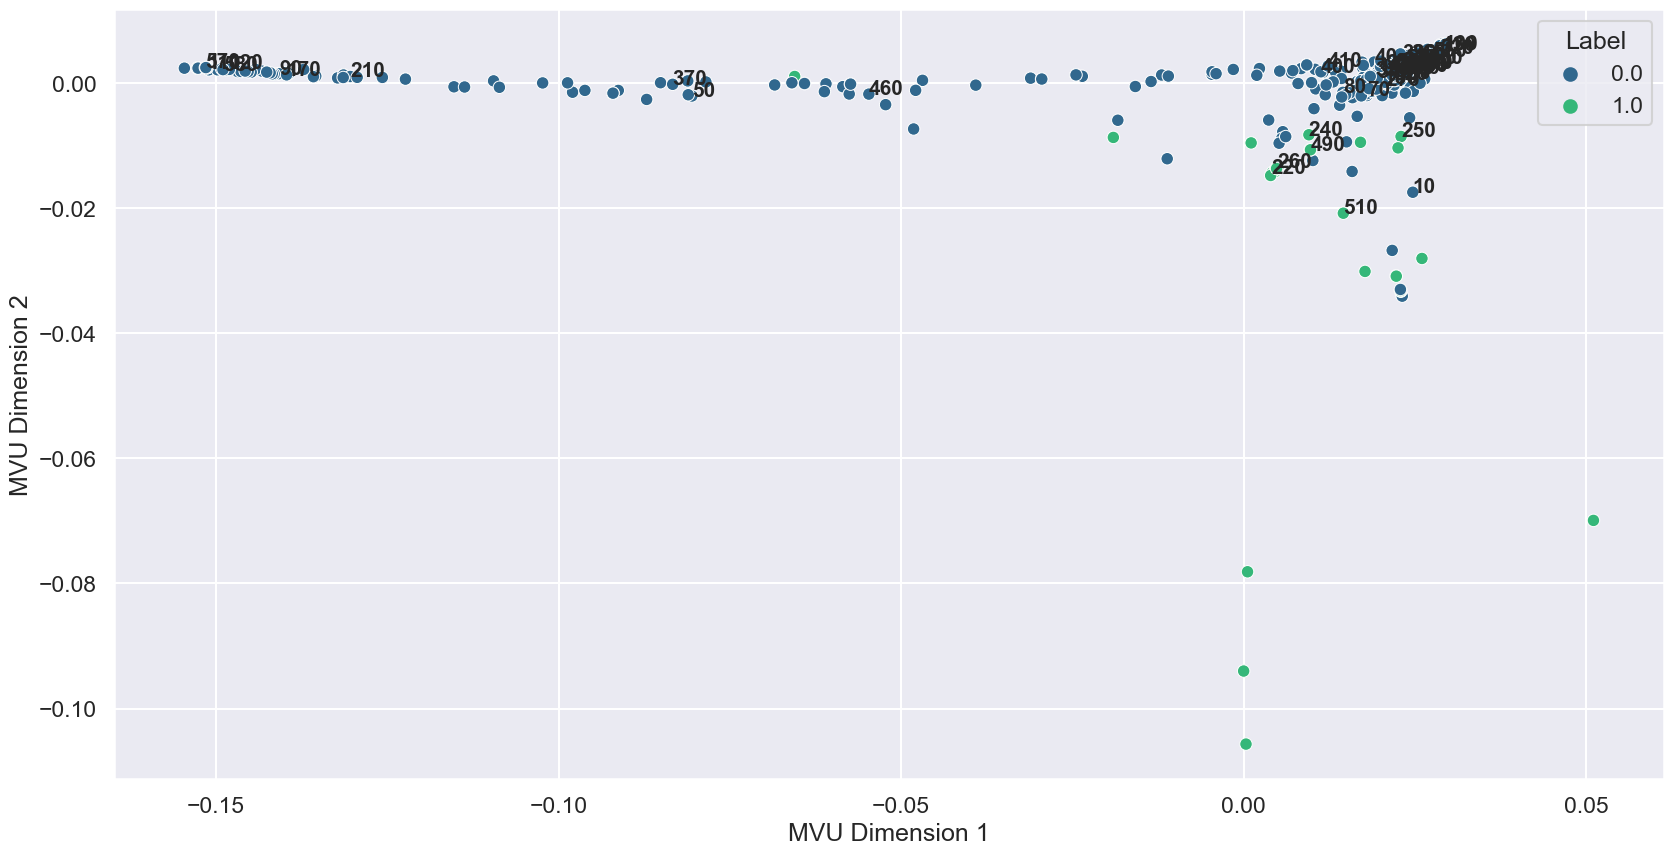

In [623]:
mvu_df = MVU_plot_1(120, 4, 2, combined_pcas.values, hm_pca_df_y['label'])

# Data enhancement

In [17]:
def enhance_data_with_noise(data, prob, size, sdev):
    indices = np.random.choice(data.index, 
                                   size, 
                                   replace=True, 
                                   p = data[prob])
    
    pert_x = np.random.normal(0, sdev, size).round().astype(int)
    pert_y = np.random.normal(0, sdev, size).round().astype(int)

    x = data.loc[indices][['click_x_bin', 'click_y_bin']] + np.array((pert_x, pert_y)).reshape(-1,2)
    x_bin_max = data['click_x_bin'].max()
    y_bin_max = data['click_y_bin'].max()
    
    x[x['click_x_bin'] < 0]['click_x_bin'] = 0
    x[x['click_y_bin'] < 0]['click_y_bin'] = 0
    x[x['click_x_bin'] > x_bin_max]['click_x_bin'] = x_bin_max
    x[x['click_y_bin'] > y_bin_max]['click_y_bin'] = y_bin_max
    
    x = x.groupby(['click_x_bin','click_y_bin']).size().reset_index(name = 'clicks_sum')

    tt = pd.DataFrame(list(product(range(0,x_bin_max+1), range(0,y_bin_max+1))), 
                      columns=['click_x_bin', 'click_y_bin'])

    data_obs_merged = tt.merge(x, on = ['click_x_bin','click_y_bin'], how = 'left').fillna(0)
#    data_obs_merged['boots_clicks'].sum()
    return data_obs_merged

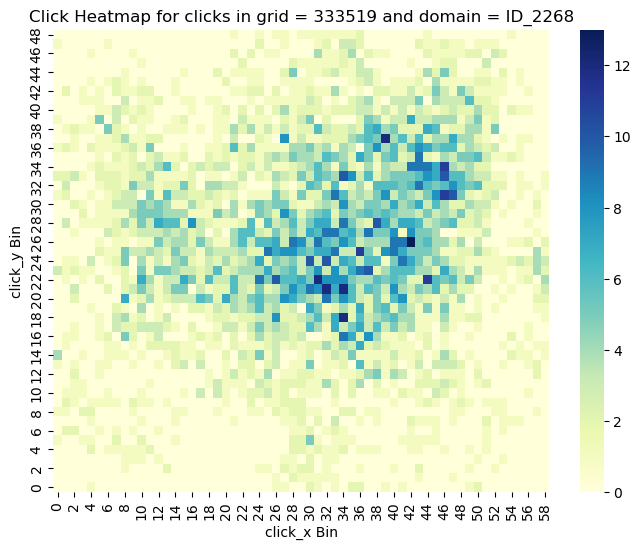

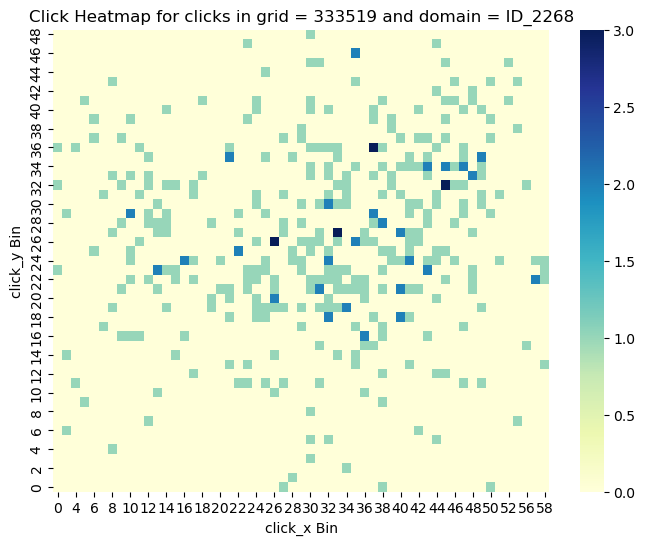

In [18]:
# example

GRID_ID = 333519
ID = 'ID_2268'

data_obs = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                             (aggregated_clicks.domain == ID)]

data_obs['proba'] = data_obs['clicks_sum']/data_obs['clicks_sum'].sum()


ex = enhance_data_with_noise(data_obs, 'proba', 5000, 2)

click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

plt.figure(figsize=(8, 6))

sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")

plt.title(f'Click Heatmap for clicks in grid = {GRID_ID} and domain = {ID}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
#plt.savefig(f'hm_{ID}_{GRID_ID}.png', bbox_inches='tight')
plt.show()

ex = data_obs
click_matrix = ex.pivot("click_y_bin","click_x_bin", "clicks_sum").fillna(0)

plt.figure(figsize=(8, 6))

sns.heatmap(click_matrix, 
            cmap = "YlGnBu", 
            annot = False, 
            cbar = True, 
            fmt = "g")

plt.title(f'Click Heatmap for clicks in grid = {GRID_ID} and domain = {ID}')
plt.xlabel('click_x Bin')
plt.ylabel('click_y Bin')
plt.gca().invert_yaxis() 
#plt.savefig(f'hm_{ID}_{GRID_ID}.png', bbox_inches='tight')
plt.show()

In [19]:
# chi squared test function with noise enhancement:

def Chi_squared_test_enh(aggregated_clicks, aggregated_clicks_by_grid, ID, GRID_ID, samp_size, stdev):
    observed = aggregated_clicks[(aggregated_clicks.grid_id == GRID_ID) &
                                 (aggregated_clicks.domain == ID)]
    
    observed['proba'] = observed['clicks_sum']/observed['clicks_sum'].sum()
    
    observed = enhance_data(observed, 'proba', samp_size, stdev)
    
    click_stat_grid = aggregated_clicks_by_grid[aggregated_clicks_by_grid.grid_id == GRID_ID]
    click_stat_grid = click_stat_grid.copy()
    click_stat_grid['bin_prob'] = click_stat_grid['clicks_sum']/click_stat_grid['clicks_sum'].sum()

    observed_freq = observed.merge(click_stat_grid, 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    observed_freq = observed[['click_x_bin',
                              'click_y_bin',
                              'clicks_sum']].merge(click_stat_grid[['click_x_bin',
                                                    'click_y_bin',
                                                    'bin_prob']], 
                                   on=['click_x_bin',
                                       'click_y_bin'], 
                                   how='right').fillna(0)

    total_observations = observed_freq['clicks_sum'].sum()
    observed_freq['Expected'] = observed_freq['bin_prob'] * total_observations

    chi_square_stat, p_value = chisquare(f_obs = observed_freq['clicks_sum'], 
                                         f_exp = observed_freq['Expected'])
    
    return chi_square_stat, p_value, total_observations

# Cluster Approach

In [642]:
def enhance_data_with_noise_pixels(data, prob, size, sdev):
    indices = np.random.choice(data.index, 
                                   size, 
                                   replace=True, 
                                   p = data[prob])
    
    pert_x = np.random.normal(0, sdev, size).round().astype(int)
    pert_y = np.random.normal(0, sdev, size).round().astype(int)

    x = data.loc[indices][['click_x', 'click_y']] + np.array((pert_x, pert_y)).reshape(-1,2)
    x_bin_max = data['display_width'].max()
    y_bin_max = data['display_height'].max()
    
    x[x['click_x'] < 0]['click_x'] = 0
    x[x['click_y'] < 0]['click_y'] = 0
    x[x['click_x'] > x_bin_max]['click_x'] = x_bin_max
    x[x['click_y'] > y_bin_max]['click_y'] = y_bin_max
    
    x = x.groupby(['click_x','click_y']).size().reset_index(name = 'clicks_sum')

    tt = pd.DataFrame(list(product(range(0,x_bin_max+1), range(0,y_bin_max+1))), 
                      columns=['click_x', 'click_y'])

    data_obs_merged = tt.merge(x, on = ['click_x','click_y'], how = 'left').fillna(0)
#    data_obs_merged['boots_clicks'].sum()
    return data_obs_merged


In [643]:
def enhance_data(data, prob, size, sdev):
    indices = np.random.choice(data.index, 
                                   size, 
                                   replace=True, 
                                   p = data[prob])
    
    pert_x = np.random.normal(0, sdev, size).round().astype(int)
    pert_y = np.random.normal(0, sdev, size).round().astype(int)

    x = data.loc[indices][['click_x_bin', 'click_y_bin']] + np.array((pert_x, pert_y)).reshape(-1,2)
    x_bin_max = data['click_x_bin'].max()
    y_bin_max = data['click_y_bin'].max()
    
    x[x['click_x_bin'] < 0]['click_x_bin'] = 0
    x[x['click_y_bin'] < 0]['click_y_bin'] = 0
    x[x['click_x_bin'] > x_bin_max]['click_x_bin'] = x_bin_max
    x[x['click_y_bin'] > y_bin_max]['click_y_bin'] = y_bin_max
    
    x = x.groupby(['click_x_bin','click_y_bin']).size().reset_index(name = 'clicks_sum')

    tt = pd.DataFrame(list(product(range(0,x_bin_max+1), range(0,y_bin_max+1))), 
                      columns=['click_x_bin', 'click_y_bin'])

    data_obs_merged = tt.merge(x, on = ['click_x_bin','click_y_bin'], how = 'left').fillna(0)
#    data_obs_merged['boots_clicks'].sum()
    return data_obs_merged

 - keep 3rd cluster
 - more refined grid search

----------------------------------------
----------------------------------------
----------------------------------------
Epsilon: 0.10
Estimated number of clusters: 3
Estimated number of noise points: 66208
Pct of noise points: 0.662080


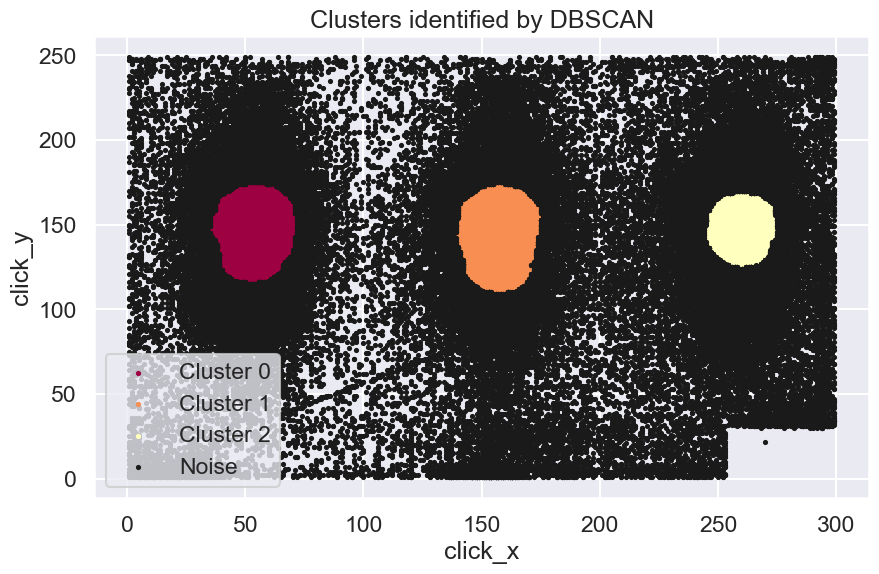

-----------------------------------------------------
3rd cluster not noise; Percentage noise: 0.66208
Epsilon: 0.10 delta pct thres: 0.00 Pct_thres: 0.66

 Broken pct: 0.86, Total in CB: 52, Missed in CB: 0, Pct missed: 0.00, Not in CB: 294
confusion matrix (rate) ((TPR,FNR),(FPR,TNR)):
 ( 1.00 , 0.00 )
 ( 0.84 , 0.16 )

-----------------------
Epsilon: 0.10 delta pct thres: 0.00 Pct_thres: 0.69

 Broken pct: 0.56, Total in CB: 52, Missed in CB: 1, Pct missed: 0.02, Not in CB: 176
confusion matrix (rate) ((TPR,FNR),(FPR,TNR)):
 ( 0.98 , 0.02 )
 ( 0.50 , 0.50 )

-----------------------
Epsilon: 0.10 delta pct thres: 0.00 Pct_thres: 0.73

 Broken pct: 0.33, Total in CB: 52, Missed in CB: 1, Pct missed: 0.02, Not in CB: 82
confusion matrix (rate) ((TPR,FNR),(FPR,TNR)):
 ( 0.98 , 0.02 )
 ( 0.23 , 0.77 )

-----------------------
Epsilon: 0.10 delta pct thres: 0.00 Pct_thres: 0.76

 Broken pct: 0.24, Total in CB: 52, Missed in CB: 1, Pct missed: 0.02, Not in CB: 44
confusion matrix (rate) (

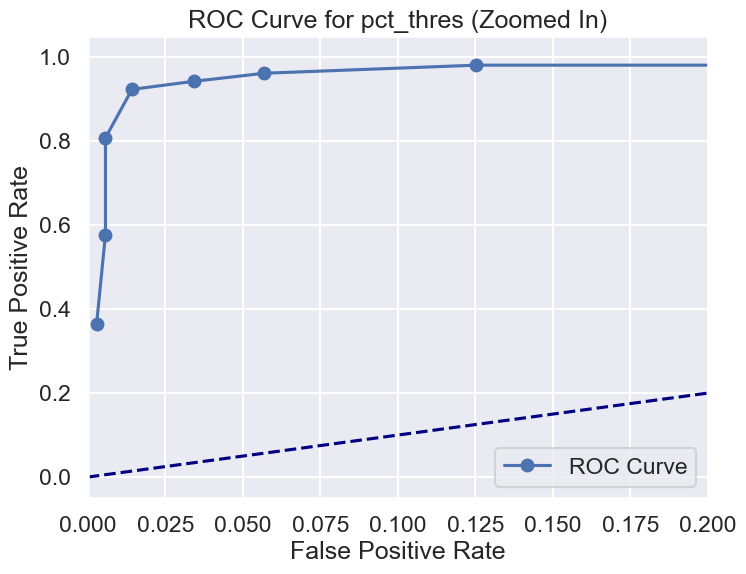

ROC AUC: 0.82


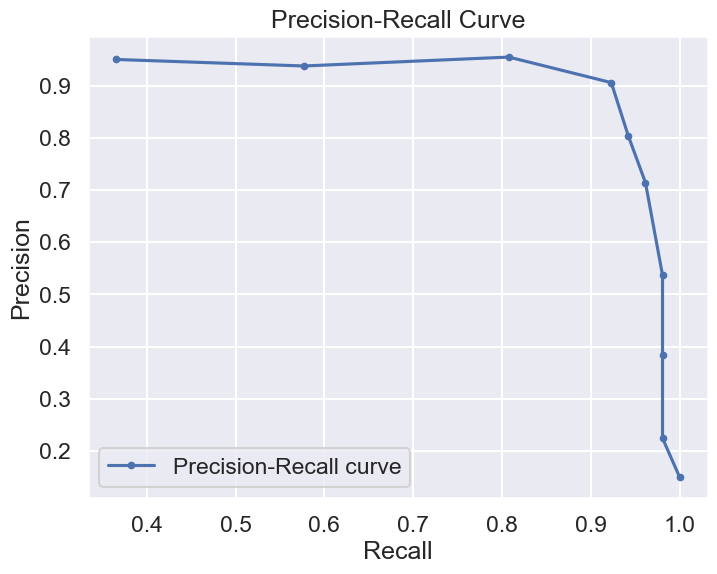

----------------------------------------
----------------------------------------
----------------------------------------
Epsilon: 0.12
Estimated number of clusters: 3
Estimated number of noise points: 46783
Pct of noise points: 0.467830


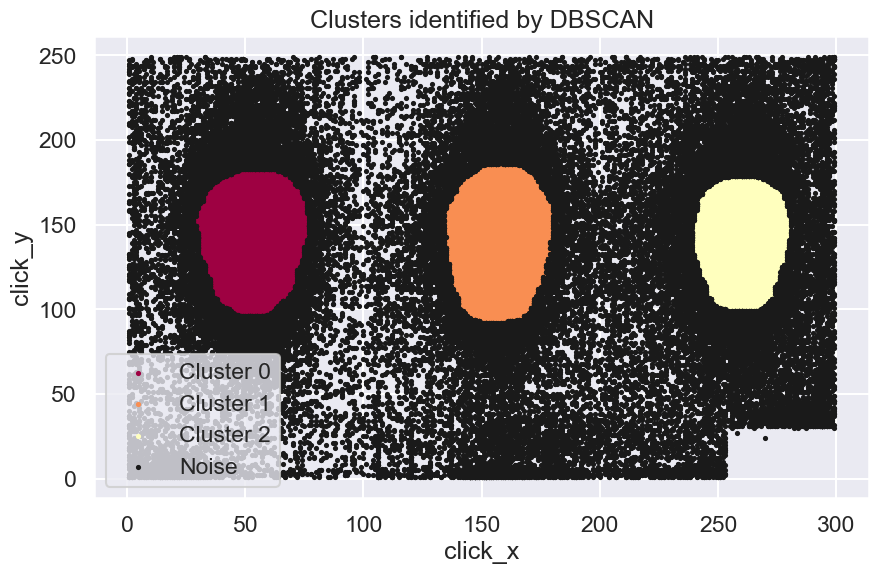

-----------------------------------------------------
3rd cluster not noise; Percentage noise: 0.46783
Epsilon: 0.12 delta pct thres: 0.00 Pct_thres: 0.47

 Broken pct: 0.76, Total in CB: 52, Missed in CB: 0, Pct missed: 0.00, Not in CB: 255
confusion matrix (rate) ((TPR,FNR),(FPR,TNR)):
 ( 1.00 , 0.00 )
 ( 0.73 , 0.27 )

-----------------------
Epsilon: 0.12 delta pct thres: 0.00 Pct_thres: 0.52

 Broken pct: 0.40, Total in CB: 52, Missed in CB: 1, Pct missed: 0.02, Not in CB: 111
confusion matrix (rate) ((TPR,FNR),(FPR,TNR)):
 ( 0.98 , 0.02 )
 ( 0.32 , 0.68 )

-----------------------
Epsilon: 0.12 delta pct thres: 0.00 Pct_thres: 0.57

 Broken pct: 0.24, Total in CB: 52, Missed in CB: 1, Pct missed: 0.02, Not in CB: 44
confusion matrix (rate) ((TPR,FNR),(FPR,TNR)):
 ( 0.98 , 0.02 )
 ( 0.13 , 0.87 )

-----------------------
Epsilon: 0.12 delta pct thres: 0.00 Pct_thres: 0.63

 Broken pct: 0.17, Total in CB: 52, Missed in CB: 2, Pct missed: 0.04, Not in CB: 20
confusion matrix (rate) (

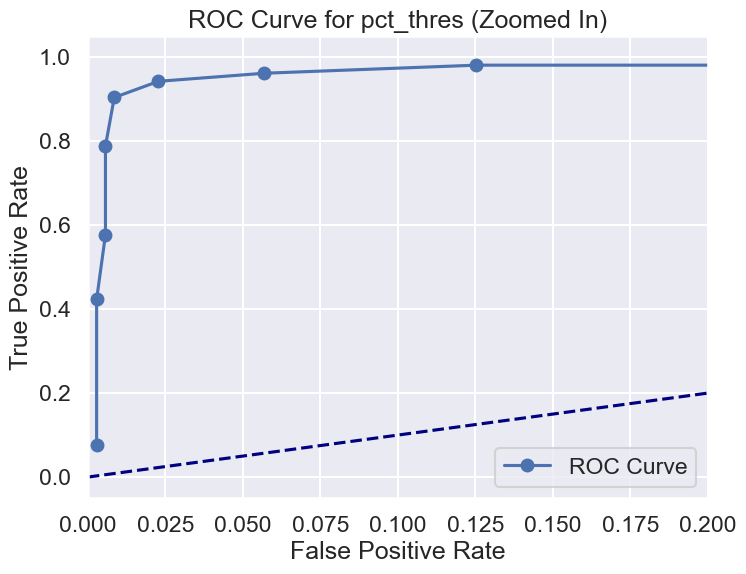

ROC AUC: 0.71


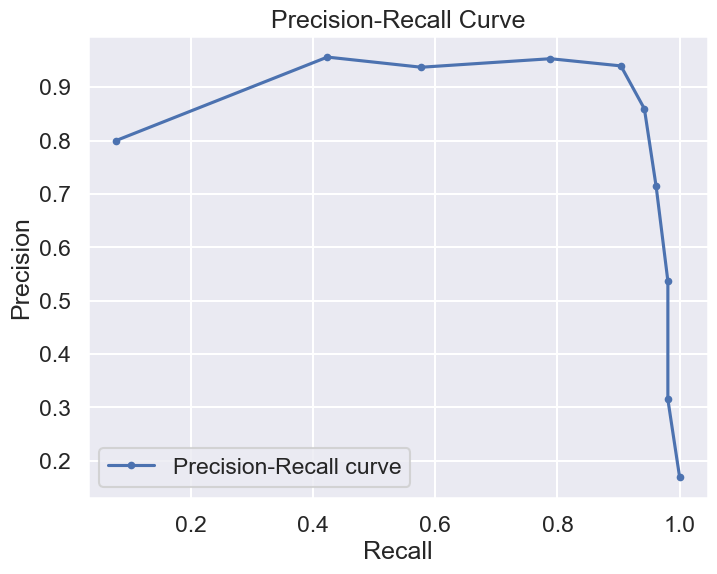

----------------------------------------
----------------------------------------
----------------------------------------
Epsilon: 0.13
Estimated number of clusters: 3
Estimated number of noise points: 37026
Pct of noise points: 0.370260


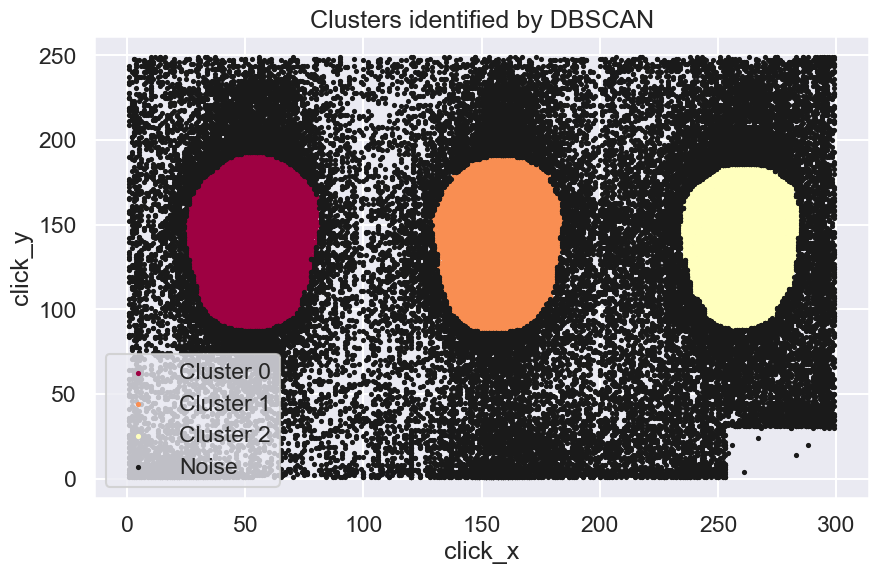

-----------------------------------------------------
3rd cluster not noise; Percentage noise: 0.37026
Epsilon: 0.13 delta pct thres: 0.00 Pct_thres: 0.37

 Broken pct: 0.65, Total in CB: 52, Missed in CB: 0, Pct missed: 0.00, Not in CB: 210
confusion matrix (rate) ((TPR,FNR),(FPR,TNR)):
 ( 1.00 , 0.00 )
 ( 0.60 , 0.40 )

-----------------------
Epsilon: 0.13 delta pct thres: 0.00 Pct_thres: 0.43

 Broken pct: 0.32, Total in CB: 52, Missed in CB: 1, Pct missed: 0.02, Not in CB: 77
confusion matrix (rate) ((TPR,FNR),(FPR,TNR)):
 ( 0.98 , 0.02 )
 ( 0.22 , 0.78 )

-----------------------
Epsilon: 0.13 delta pct thres: 0.00 Pct_thres: 0.50

 Broken pct: 0.19, Total in CB: 52, Missed in CB: 1, Pct missed: 0.02, Not in CB: 27
confusion matrix (rate) ((TPR,FNR),(FPR,TNR)):
 ( 0.98 , 0.02 )
 ( 0.08 , 0.92 )

-----------------------
Epsilon: 0.13 delta pct thres: 0.00 Pct_thres: 0.56

 Broken pct: 0.15, Total in CB: 52, Missed in CB: 3, Pct missed: 0.06, Not in CB: 13
confusion matrix (rate) ((

In [ ]:
from scipy.stats import binomtest
from IPython.display import clear_output
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve, auc, precision_recall_curve


np.random.seed(43)
GRID_ID = 333346

data_val, data_test = train_test_split(data_heatmap[(data_heatmap.grid_id == GRID_ID)]['domain'].unique(), 
                                       test_size=0.33, 
                                       random_state = 42)

NR_OF_SAMPLES = 100000
NR_OF_RANDOM_SEARCHES = 31
NR_OF_THRESH_ = 10

eps_choice = np.linspace(0.1,0.4, 21)
#delta_pct_choice = np.linspace(0.0, 0.8, 10)
include_3rd_cluster = [False]


for epsilon in eps_choice:
    print('----------------------------------------')
    print('----------------------------------------')
    print('----------------------------------------')
    print(f'Epsilon: {epsilon:.2f}')
    
    ex_agg = data_heatmap[data_heatmap.grid_id == GRID_ID].groupby(['click_x','click_y'], 
                                                                       as_index=False)['clicks'].sum()
    ex_agg['proba']          = ex_agg['clicks']/ex_agg['clicks'].sum()
    ex_agg['display_height'] = data_heatmap['display_height'].max()
    ex_agg['display_width']  = data_heatmap['display_width'].max()

    ex_agg_ = enhance_data_with_noise_pixels(ex_agg, 'proba', NR_OF_SAMPLES, 0)

    ex = \
    ex_agg_.loc[ex_agg_.index.repeat(ex_agg_['clicks_sum'])].reset_index(drop=True)[['click_x','click_y']]

    scaler = StandardScaler()
    ex_ = scaler.fit_transform(ex)

    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(ex_)
    
    db = DBSCAN(eps = epsilon,
                min_samples = 1000).fit(ex_)

    labels        = db.labels_
    n_clusters_   = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_      = list(labels).count(-1)
    pct_noise_    = (n_noise_/labels.shape[0])
    ex['cluster'] = labels

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Pct of noise points: %f" % pct_noise_)


    plt.figure(figsize=(10, 6))
    unique_labels = set(labels)
    for label in unique_labels:
        if label == -1: #noise
            color = 'k' 
        else:
            color = plt.cm.Spectral(float(label) / len(unique_labels))
        cluster_data = ex[ex['cluster'] == label]
        plt.scatter(cluster_data['click_x'], 
                    cluster_data['click_y'], 
                    s=5, 
                    c=[color], 
                    label=f'Cluster {label}' if label != -1 else 'Noise')

    plt.title('Clusters identified by DBSCAN')
    plt.xlabel('click_x')
    plt.ylabel('click_y')
    plt.legend()
    plt.show()

    #------------------------------------------------------------------------
    for inc_3rd in include_3rd_cluster:
        if inc_3rd:
            n_noise_      = list(labels).count(-1) + list(labels).count(3)
            pct_noise_    = (n_noise_/labels.shape[0])
            print('-----------------------------------------------------')
            print(f'3rd cluster is noise; Percentage noise: {pct_noise_}')
        else:
            print('-----------------------------------------------------')
            print(f'3rd cluster not noise; Percentage noise: {pct_noise_}')

    #------------------------------------------------------------------------

        p_bulk_noise = pct_noise_
        p_bulk_success = 1- p_bulk_noise
        pct_thres = 0
        
        tpr_list = []
        fpr_list = []
        precision_list = []
        recall_list = []
        TPR = 1

        for pct_thres in np.linspace(p_bulk_noise, 0.95, NR_OF_THRESH_):

            nr_of_broken       = 0
            nr_of_broken_in_cb = 0
            nr_in_cb_so_far    = 0
            nr_                = 0

            if TPR < 0.09:
                break

            print(f'Epsilon: {epsilon:.2f}',
                  f'delta pct thres: {delta_pct_thres:.2f}',
                  f'Pct_thres: {pct_thres:.2f}\n')

            for ID in data_val:
                nr_ += 1
                data_obs = data_heatmap[(data_heatmap.grid_id == GRID_ID) &
                                         (data_heatmap.domain == ID)]
                data_obs['proba'] = data_obs['clicks']/data_obs['clicks'].sum()

                data_obs_enh = enhance_data_with_noise_pixels(data_obs, 'proba', 5000, 10)
                test = data_obs_enh.loc[data_obs_enh.index.repeat(data_obs_enh['clicks_sum'])].reset_index(
                    drop=True)
                test = test[['click_x','click_y']]

                test_ = scaler.transform(test)
                distances, indices = nn.kneighbors(test_)

                predicted_labels = labels[indices.flatten()]
                if inc_3rd:
                    test['predicted_cluster'] = predicted_labels
                    test_noise_pct = test[(test.predicted_cluster < 0) | 
                                      (test.predicted_cluster > 2)].shape[0]/test.shape[0]
                    test_success_pct = 1 - test_noise_pct

                    bt = binomtest(test[(test.predicted_cluster >= 0) &
                                    (test.predicted_cluster < 3)].shape[0], 
                                   n = test.shape[0], 
                                   p = p_bulk_success, 
                                   alternative='less')
                else:
                    test['predicted_cluster'] = predicted_labels
                    test_noise_pct = test[(test.predicted_cluster < 0)].shape[0]/test.shape[0]
                    test_success_pct = 1 - test_noise_pct

                    bt = binomtest(test[(test.predicted_cluster >= 0)].shape[0], 
                                   n = test.shape[0], 
                                   p = p_bulk_success, 
                                   alternative='less')

                if test_noise_pct > pct_thres:
                    nr_of_broken += 1
                    if ID in cb_333346:
                        nr_of_broken_in_cb+=1

                if ID in cb_333346:
                    nr_in_cb_so_far += 1

                if nr_in_cb_so_far == 0:
                    xx_ = 0
                else:
                    xx_ = (nr_in_cb_so_far - nr_of_broken_in_cb)/nr_in_cb_so_far

            print(f' Broken pct: {nr_of_broken/nr_:.2f},',
                  f'Total in CB: {nr_in_cb_so_far},',
                  f'Missed in CB: {nr_in_cb_so_far - nr_of_broken_in_cb},',
                  f'Pct missed: {xx_:.2f},',
                  f'Not in CB: {(nr_of_broken-nr_of_broken_in_cb)}')
            
            total_pop = len(data_val)
            TPR = nr_of_broken_in_cb/nr_in_cb_so_far
            FNR = 1-TPR
            FPR = (nr_of_broken-nr_of_broken_in_cb)/(total_pop-nr_in_cb_so_far)
            TNR = 1-FPR
            
            Recall = TPR
            if (nr_of_broken_in_cb + (nr_of_broken - nr_of_broken_in_cb)) > 0:
                Precision = nr_of_broken_in_cb / (nr_of_broken_in_cb + (nr_of_broken - nr_of_broken_in_cb))
            else:
                Precision = 0

            precision_list.append(Precision)
            recall_list.append(Recall)
            
            tpr_list.append(TPR)
            fpr_list.append(FPR)
            
            print(f'confusion matrix (rate) ((TPR,FNR),(FPR,TNR)):\n',
                  f'( {TPR:.2f} , {FNR:.2f} )\n',
                  f'( {FPR:.2f} , {TNR:.2f} )\n')
            print('-----------------------')

        plt.figure(figsize=(8, 6))
        plt.plot(fpr_list, tpr_list, marker='o', linestyle='-', label='ROC Curve')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
        plt.xlim([0.0, 0.2])  # Adjust to zoom into lower FPRs if necessary
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for pct_thres (Zoomed In)')
        plt.legend(loc='lower right')
        plt.show()

        roc_auc_value = auc(fpr_list, tpr_list)
        print(f"ROC AUC: {roc_auc_value:.2f}")
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall_list, precision_list, marker='.', label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()
        
    #clear_output(wait=True)